In [1]:
import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
from statannotations.Annotator import Annotator
import pickle
from scipy.stats import chi2_contingency
import scipy
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib.lines import Line2D
import requests

def get_go_term_details(go_id):
    url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{go_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if "results" in data and len(data["results"]) > 0:
            go_term = data["results"][0]
            return {
                "id": go_term["id"],
                "name": go_term["name"],
                "namespace": go_term["aspect"],
                "definition": go_term["definition"]["text"]
            }
    return None

In [2]:
def assign_group(protein, group1_name: list, group1_string, group2_name: list, group2_string ):
    if protein in group1_name:
        return group1_string
    elif protein in group2_name:
        return group2_string
    else:
        return 'Not in any group'


def count_consecutive_stretches_of_1(lst, label="IDR"):
    count = 0
    current_stretch = False
    start_stop_list = []
    for index, num in enumerate(lst):
        if num == 1:
            if current_stretch == False:
                start = index
                current_stretch = True
                count += 1
        else:
            if current_stretch == True:
                current_stretch = False
                stop = index
                start_stop_list.append((start, stop, label))
    if current_stretch == True:
        start_stop_list.append((start, len(lst), label))
    return start_stop_list
### count_consecutive_stretches_of_1([1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], "IDR") --> [(0, 4, 'IDR'), (13, 21, 'IDR')]

def is_either_between(low_range, high_range, a, b):
    ### a and b are start and end of the motif
    ### low_range and high_range are the start and end of the IDR
    ### it will output true if the motif only as much as toucehs the IDR region
    return (low_range <= a <= high_range) or (low_range <= b <= high_range)

# print(is_either_between(10,20, 5,50))
# print(is_either_between(10,70, 65,80))


def merge_duplicates(input_string):
    result = ""
    previous_char = None

    for char in input_string:
        if char != previous_char:
            result += char
            previous_char = char

    return result

def cat_string(input_string):
    if "DIDI" in input_string and "IDID" in input_string:
        return "more\ncomplex"
    elif "IDID" in input_string:
        return "IDID"
    elif "DIDI" in input_string:
        return "DIDI"
    elif "IDI" in input_string:
        return "IDI"
    elif "DID" in input_string:
        return "DID"
    elif "ID" in input_string:
        return "ID"
    elif "DI" in input_string:
        return "DI"
    elif "I" in input_string:
        return "I"
    elif "D" in input_string:
        return "D"
    else:
        return "None"
        
def make_struct_string(list_comb):
    struct_string = ""
    for el in list_comb:
        if el[-1] == "IDR":
            struct_string += "I"
        elif el[-1] == "MOTIF":
            struct_string += "M"
        elif el[-1] == "NABIND":
            struct_string += "R"
        elif el[-1] == "DOMAIN":
            struct_string += "D"
    return struct_string

def assign_groups_advanced(protein, group1_name: list, group1_string, group2_name: list, group2_string, group3_name: list, group3_string, group4_name: list, group4_string ):
    if protein in group1_name:
        return group1_string
    elif protein in group2_name:
        return group2_string
    elif protein in group3_name:
        return group3_string
    elif protein in group4_name:
        return group4_string
    else:                                                  
        return 'Not in any group'

def calculate_domain_motif_distance(domain, motif, mode):
    """
    Calculate the distance between two regions in a protein sequence.

    Parameters:
    region1 (tuple): (start, end) of the first region
    region2 (tuple): (start, end) of the second region

    Returns:
    int: Distance between the two regions (0 if overlapping)
    """
    start1, end1 = domain
    domain_center = end1 - (end1 - start1) / 2
    start2, end2 = motif
    motif_center = end2 - (end2 - start2) / 2

    # print(domain)
    # print(motif)
    # If regions overlap, return 0
    if mode == "e":
        if max(start1, start2) <= min(end1, end2):
            return 0
        elif start1 < start2: ## domain left of motif --> pos    DOM------x-----MOTIF
            return start2 - end1
        elif start1 > start2: ## domain right of themotif --> neg       MOTIF-----x------DOM
            return end2 - start1
    elif mode=="c":
        if max(start1, start2) <= min(end1, end2):
            return 0
        else:
            return motif_center - domain_center

    # Calculate distance based on order
    # return max(start1, start2) - min(end1, end2)

# # Example Usage
# regionA = (10, 15)
# motif = (20, 30)
# regionC = (25, 35)  # Overlapping case
# regionD = (36, 50)  # Overlapping case

# # ----------AAAAA
# # --------------------MMMMMMMMMM
# # -------------------------CCCCCCCCCC
# # ------------------------------------DDDDDDDDDDDDDD

# print(calculate_domain_motif_distance(regionA, motif))  # Output: 5
# print(calculate_domain_motif_distance(regionC, motif))  # Output: 0
# print(calculate_domain_motif_distance(regionD, motif))  # Output: -6


In [3]:
##### here choose either human, mouse or merged

choice = 'human'


motif_info_set_df = pd.read_parquet(r'/mnt/d/phd/scripts/3_mus_musculus/output/merged/annotated_sets/GAR_motif_Wang_set_merged_v3_annot.parquet')
annotated_IDR_df_1 = pd.read_parquet(r"/mnt/d/phd/scripts/1_feature_curation/output/annotation_datasets/all_IDR_human.parquet")
annotated_IDR_df_2 = pd.read_parquet(r"/mnt/d/phd/scripts/3_mus_musculus/output/mouse/annotation_datasets/all_IDR_mouse.parquet")
annotated_IDR_df_1['source'] = 'human'
annotated_IDR_df_2['source'] = 'mouse'
annotated_IDR_df = pd.concat([annotated_IDR_df_1, annotated_IDR_df_2])

annotated_domain_df_1 = pd.read_csv(r"/mnt/d/phd/scripts/1_feature_curation/output/annotation_datasets/all_domains_human.csv")
annotated_domain_df_2 = pd.read_csv(r"/mnt/d/phd/scripts/3_mus_musculus/output/mouse/annotation_datasets/all_domains_mouse.csv")
annotated_domain_df_1['source'] = 'human'
annotated_domain_df_2['source'] = 'mouse'
annotated_domain_df = pd.concat([annotated_domain_df_1, annotated_domain_df_2])

if choice == 'human':
    motif_info_set_df = motif_info_set_df[motif_info_set_df['source'] == 'HUMAN']
elif choice == 'mouse':
    motif_info_set_df = motif_info_set_df[motif_info_set_df['source'] == 'MOUSE']
else:
    pass

annotated_domain_df["GO_identifiers"] = annotated_domain_df["GO_identifiers"].apply(lambda x: literal_eval(str(x)))
annotated_domain_df["GO_names"] = annotated_domain_df["GO_names"].apply(lambda x: literal_eval(str(x)))

In [4]:
# annotated_domain_df

GO_ID_dict = {}

for _, row in annotated_domain_df.iterrows():
    keys = row["GO_identifiers"]
    values = row["GO_names"]
    
    # Create a mapping for keys and values in the same row
    row_dict = dict(zip(keys, values))
    
    # Update the main dictionary
    GO_ID_dict.update(row_dict)
print(len(GO_ID_dict))
print("Resulting Dictionary:", GO_ID_dict)

1093
Resulting Dictionary: {'GO:0035556': 'intracellular signal transduction', 'GO:0016791': 'phosphatase activity', 'GO:0046856': 'phosphatidylinositol dephosphorylation', 'GO:0003723': 'RNA binding', 'GO:0022857': 'transmembrane transporter activity', 'GO:0008083': 'growth factor activity', 'GO:0016020': 'membrane', 'GO:0004252': 'serine-type endopeptidase activity', 'GO:0006508': 'proteolysis', 'GO:0004222': 'metalloendopeptidase activity', 'GO:0000976': 'transcription cis-regulatory region binding', 'GO:0005515': 'protein binding', 'GO:0006355': 'regulation of DNA-templated transcription', 'GO:0003700': 'DNA-binding transcription factor activity', 'GO:0005525': 'GTP binding', 'GO:0008270': 'zinc ion binding', 'GO:0043565': 'sequence-specific DNA binding', 'GO:1990817': 'poly(A) RNA polymerase activity', 'GO:0000724': 'double-strand break repair via homologous recombination', 'GO:0000166': 'nucleotide binding', 'GO:0004812': 'aminoacyl-tRNA ligase activity', 'GO:0005524': 'ATP bindi

In [5]:
ver = "v3"
proteins_sets_dict = {}

set_names, set_list, set_files = [], [], []

GAR_full = ["GAR_subset_full"]
set_names.append("GAR_full")
set_files.append(GAR_full)
#########
GAR_LLPS_pos = ["4_LLPS_positive_set_and_GAR_subset",
                "5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset"
                ]
set_names.append("GAR_LLPS_pos")
set_files.append(GAR_LLPS_pos)
###################
GAR_LLPS_pos_NA_neg = ["4_LLPS_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_LLPS_pos_NA_neg")
set_files.append(GAR_LLPS_pos_NA_neg)
#########

GAR_LLPS_neg = ["6_NA_positive_set_and_GAR_subset",
                "7_GAR_subset_only"
            ]
set_names.append("GAR_LLPS_neg")
set_files.append(GAR_LLPS_neg)
#################
GAR_LLPS_neg_NA_pos = ["6_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_LLPS_neg_NA_pos")
set_files.append(GAR_LLPS_neg_NA_pos)

#########
GAR_NA_pos = ["5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset",
            "6_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_NA_pos")
set_files.append(GAR_NA_pos)
#########
GAR_NA_neg = ["4_LLPS_positive_set_and_GAR_subset",
            "7_GAR_subset_only"
            ]
set_names.append("GAR_NA_neg")
set_files.append(GAR_NA_neg)
#########
GAR_pos = ["5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_pos")
set_files.append(GAR_pos)
#########
#########
GAR_neg = ["7_GAR_subset_only"
            ]
set_names.append("GAR_neg")
set_files.append(GAR_neg)
#########



set_list = []
set_dict = {}

for i,member in enumerate(set_files):
    set_list_temp = []
    for el in member:
        with open(r'/mnt/d/phd/scripts/3_mus_musculus/output/merged/final_set_lists/' + ver + r'/' + el +".txt", "r") as fl:
            for line in fl:
                set_list_temp.append(line.strip())
    set_dict[set_names[i]] = set_list_temp
    set_list.append(set_list_temp)
set_list_temp = []
with open(r'/mnt/d/phd/scripts/raw_data/proteomes/list_of_all_proteins_merged.txt') as fl:
    for line in fl:
        set_list_temp.append(line.strip())
set_list.append(set_list_temp)
set_names.append('full_proteome')
set_dict['full_proteome'] = set_list_temp

proteins_sets_dict[ver] = set_dict

pos_prot_list = set_list[set_names.index("GAR_LLPS_pos")]
neg_prot_list = set_list[set_names.index("GAR_LLPS_neg")]


set_prot_list = list(set(pos_prot_list + neg_prot_list))

pfam_annotated_domain_df = annotated_domain_df[annotated_domain_df['databases'].apply(lambda x: "pfam" in x)]

977      Q15366
2435     Q8TCS8
2571     Q92945
3716     O75179
4225     Q00341
          ...  
25377    P57722
25379    P57724
25659    Q3UE17
27254    Q8VDJ3
27822    Q9D8Z1
Name: protein_name, Length: 67, dtype: object

In [12]:
# Creating a dictionary based on the conditions
domain_GO_dict = {row['name']: row['GO_identifiers'] for index, row in pfam_annotated_domain_df.iterrows() if len(row['GO_identifiers']) > 0}

print(len(domain_GO_dict))
print(domain_GO_dict)
all_GO_terms = []
for value in domain_GO_dict.values():
    if isinstance(value, list):
        all_GO_terms.extend(value)
    else:
        all_GO_terms.append(value)
print(len(all_GO_terms))
print(all_GO_terms)
all_GO_terms = list(set(all_GO_terms))
print(len(all_GO_terms))
print(all_GO_terms)

1308
{'Doublecortin domain': ['GO:0035556'], 'RNA recognition motif domain': ['GO:0003723'], 'SAC domain': ['GO:0016791'], 'PDGF/VEGF domain': ['GO:0008083', 'GO:0016020'], 'Serine proteases, trypsin domain': ['GO:0004252', 'GO:0006508'], 'Peptidase M13, N-terminal domain': ['GO:0006508'], 'Peptidase M13, C-terminal domain': ['GO:0004222', 'GO:0006508'], 'Interferon regulatory factor, DNA-binding domain': ['GO:0000976'], 'Fibronectin type III': ['GO:0005515'], 'Krueppel-associated box': ['GO:0006355'], 'Basic-leucine zipper domain': ['GO:0003700', 'GO:0006355'], 'Zinc finger, nuclear hormone receptor-type': ['GO:0003700', 'GO:0008270', 'GO:0043565', 'GO:0006355'], 'Poly(A) polymerase, RNA-binding domain': ['GO:0003723'], 'Poly(A) polymerase, central domain': ['GO:1990817'], 'BRCA2, OB1': ['GO:0000724'], 'Aminoacyl-tRNA synthetase, class Ia': ['GO:0000166', 'GO:0004812', 'GO:0005524', 'GO:0006418'], 'Methionyl/Valyl/Leucyl/Isoleucyl-tRNA synthetase, anticodon-binding': ['GO:0004812', 'G

7006
4350
51
['Zinc finger C2H2-type', 'Protein kinase domain', 'Immunoglobulin V-set domain', 'Zinc finger, RING-type', 'Pleckstrin homology domain', 'Homeobox domain', 'EGF-like domain', 'Krueppel-associated box', 'SH3 domain', 'EF-hand domain', 'RNA recognition motif domain', 'Fibronectin type III', 'BTB/POZ domain', 'PDZ domain', 'C2 domain', 'AAA+ ATPase domain', 'Serine-threonine/tyrosine-protein kinase, catalytic domain', 'Immunoglobulin I-set', 'Serine proteases, trypsin domain', 'Myc-type, basic helix-loop-helix (bHLH) domain', 'SH2 domain', 'Ion transport domain', 'C-type lectin-like', 'Sterile alpha motif domain', 'Cadherin-like', 'SPRY domain', 'Cysteine-rich flanking region, C-terminal', 'Calponin homology domain', 'Immunoglobulin C1-set', 'Intermediate filament, rod domain', 'von Willebrand factor, type A', 'Zinc finger, LIM-type', 'Zinc finger, PHD-finger', 'B-box-type zinc finger', 'Immunoglobulin', 'Dbl homology (DH) domain', 'DEAD/DEAH box helicase domain', 'F-box dom

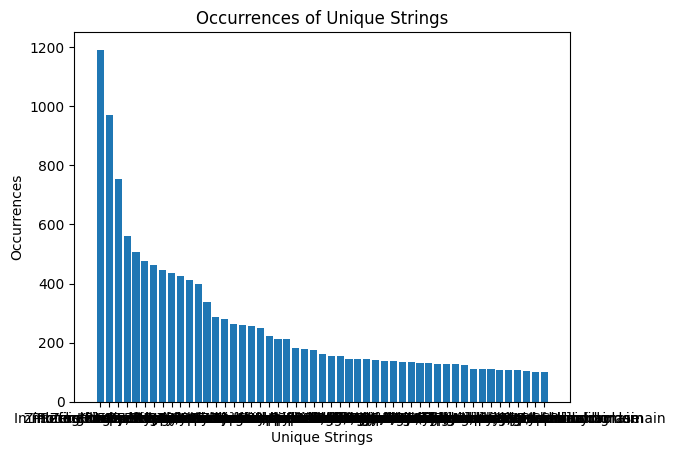

In [13]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 10))
occurrences_dict1 = annotated_domain_df['name'].value_counts().to_dict()
print(len(occurrences_dict1))
occurrences_dict2 = pfam_annotated_domain_df['name'].value_counts().to_dict()
print(len(occurrences_dict2))
occurrences_dict2_filt = {key: value for key, value in occurrences_dict2.items() if value >= 100}
print(len(occurrences_dict2_filt))


domains_to_check = list(occurrences_dict2_filt.keys())
print(domains_to_check)
print(len(domains_to_check))
# # occurrences_dict2
# # Extracting zuzkeys and values from the dictionary
# sorted_dict = dict(sorted( occurrences_dict2.items(), key=lambda item: item[1], reverse=True))
# # print(sorted_dict)
# keys = list(sorted_dict.keys())
# values = list(sorted_dict.values())
# # Creating a bar plot
# axes[0].bar(keys, values)




sorted_dict = dict(sorted( occurrences_dict2_filt.items(), key=lambda item: item[1], reverse=True))
# print(sorted_dict)
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())
plt.bar(keys, values)

# Adding labels and title
plt.xlabel('Unique Strings')
plt.ylabel('Occurrences')
plt.title('Occurrences of Unique Strings')

# Show the plot
plt.show()

In [14]:
column_name = "GO_identifiers"  # Replace with your column name
rows_with_empty_list = pfam_annotated_domain_df[column_name].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
print(f"Rows with empty lists in column '{column_name}':", rows_with_empty_list)

Rows with empty lists in column 'GO_identifiers': 26321


In [15]:
list_of_GO_terms_withNAbinding = open(r'/mnt/d/phd/scripts/raw_data/GO_terms/GO_terms_NAbinding.txt', "r").read().split("\n")[:-1]

protein_dict_with_domain_metrics = {}
for i,curr_protein in enumerate(proteins_sets_dict['v3']['full_proteome']):
    if motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein].empty:
        continue
    print(i, " out of ", len(proteins_sets_dict['v3']['full_proteome']))
    print(curr_protein)

    protein_dict_with_domain_metrics[curr_protein] = {"num_of_IDR": 0, "structure_string": "", "num_domains": 0}

    if annotated_IDR_df[annotated_IDR_df["protein_name"] == curr_protein].empty:
        list_of_IDRs = []
    else:
        curr_IDR_info = annotated_IDR_df[annotated_IDR_df['protein_name'] == curr_protein]["prediction-disorder-mobidb_lite"].tolist()[0].tolist()
        list_of_IDRs = count_consecutive_stretches_of_1(curr_IDR_info)
        list_of_IDRs_unchanged = count_consecutive_stretches_of_1(curr_IDR_info)
        # print(curr_protein)
        # print(list_of_IDRs)
        for num_IDR, idr_region in enumerate(list_of_IDRs):
            for j, m in motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein][["UniqueID", "start", "end"]].iterrows():
                if is_either_between(idr_region[0], idr_region[1],m['start'], m['end']):
                    list_of_IDRs[num_IDR] = (list_of_IDRs[num_IDR][0], list_of_IDRs[num_IDR][1], "MOTIF")
                    break
                    #### this means the motif is in between the current IDR 
        # print(list_of_IDRs)
        # print(".......")
            
        
    ### here if the motif IDR swith the label
        
    # print(curr_domain_info)
    curr_domain_info = pfam_annotated_domain_df[pfam_annotated_domain_df['protein_name'] == curr_protein]
    
    list_of_domains = []
    list_of_domains_R = []
    for i,r in curr_domain_info.iterrows():
        list_of_domains.append((r['start'], r['end'], r['name']))
        if bool(set(r['GO_identifiers']).intersection(list_of_GO_terms_withNAbinding)):
            list_of_domains_R.append((r['start'], r['end'],"NABIND"))
        else:
            list_of_domains_R.append((r['start'], r['end'],"DOMAIN"))
    
    # print(list_of_domains)
    # print(len(curr_domain_info))
    # print(curr_IDR_info)

    # print(list_of_IDRs)
    list_of_both = sorted(list_of_domains_R + list_of_IDRs, key=lambda x: x[0])
    list_of_both_old = sorted(list_of_domains_R + list_of_IDRs_unchanged, key=lambda x: x[0])
    # print(list_of_both)
    protein_dict_with_domain_metrics[curr_protein] = {   "num_of_IDR": len(list_of_IDRs),
                                                                    "structure_string": make_struct_string(list_of_both),
                                                                    "structure_string_old": make_struct_string(list_of_both_old),
                                                                    "num_domains": len(list_of_domains),
                                                                    "domains": list_of_domains,
                                                                    "IDR_bounds": list_of_IDRs
                                                                    
                                                            }
proteins_with_domain_metrics_df =pd.DataFrame(protein_dict_with_domain_metrics).transpose()
proteins_with_domain_metrics_df.reset_index(inplace=True)
proteins_with_domain_metrics_df = proteins_with_domain_metrics_df.rename(columns = {'index':'proteins'})
proteins_with_domain_metrics_df['Group'] = proteins_with_domain_metrics_df['proteins'].apply(
                                                                    assign_group,
                                                                    args= (pos_prot_list, "pos", neg_prot_list, "neg"))
proteins_with_domain_metrics_df['reduced_struct_string'] = proteins_with_domain_metrics_df['structure_string'].apply(merge_duplicates)
proteins_with_domain_metrics_df['reduced_struct_string_old'] = proteins_with_domain_metrics_df['structure_string_old'].apply(merge_duplicates)
proteins_with_domain_metrics_df['categ_reduced_struct_string_old'] = proteins_with_domain_metrics_df['reduced_struct_string_old'].apply(cat_string)
proteins_with_domain_metrics_df = proteins_with_domain_metrics_df.infer_objects()
print(proteins_with_domain_metrics_df.dtypes)
proteins_with_domain_metrics_df


48  out of  37768
Q5SSQ6
61  out of  37768
Q7Z7L8
72  out of  37768
Q8NAF0
94  out of  37768
Q9ULH4
162  out of  37768
Q8N878
238  out of  37768
P85299
281  out of  37768
Q9GZU7
321  out of  37768
O95677
369  out of  37768
Q96HM7
383  out of  37768
Q9H461
420  out of  37768
P30414
429  out of  37768
Q14674
443  out of  37768
Q5VUG0
451  out of  37768
Q7L8J4
459  out of  37768
Q8N539
486  out of  37768
Q9HBH9
509  out of  37768
O00453
531  out of  37768
P0CJ87
544  out of  37768
P86481
545  out of  37768
Q01954
569  out of  37768
Q86XE3
601  out of  37768
A0FGR8
606  out of  37768
O15014
637  out of  37768
Q13151
664  out of  37768
Q8N1G1
692  out of  37768
Q9UH36
707  out of  37768
A6NEQ0
784  out of  37768
Q99502
803  out of  37768
A0A590UJ96
824  out of  37768
P20339
908  out of  37768
B2RXF0
956  out of  37768
Q6NV74
976  out of  37768
Q96SZ5
1008  out of  37768
O15417
1059  out of  37768
Q8IUG5
1126  out of  37768
P36021
1180  out of  37768
Q9HCU4
1190  out of  37768
Q9UJV8
1196  o

,proteins,num_of_IDR,structure_string,structure_string_old,num_domains,domains,IDR_bounds,Group,reduced_struct_string,reduced_struct_string_old,categ_reduced_struct_string_old
0,Q5SSQ6,1,M,I,0,[],"[(119, 148, MOTIF)]",neg,M,I,I
1,Q7Z7L8,3,MII,III,0,[],"[(146, 196, MOTIF), (216, 315, IDR), (344, 372...",pos,MI,I,I
2,Q8NAF0,4,MDIII,IDIII,1,"[(44, 71, Zinc finger C2H2-type)]","[(0, 43, MOTIF), (138, 203, IDR), (326, 379, I...",neg,MDI,IDI,IDI
3,Q9ULH4,4,DDIDIIM,DDIDIII,3,"[(242, 287, Cysteine-rich flanking region, C-t...","[(382, 424, IDR), (576, 602, IDR), (618, 654, ...",neg,DIDIM,DIDI,DIDI
4,Q8N878,3,MDDDII,IDDDII,3,"[(58, 119, FERM, N-terminal), (271, 339, FERM,...","[(0, 40, MOTIF), (376, 400, IDR), (421, 464, I...",neg,MDI,IDI,IDI
...,...,...,...,...,...,...,...,...,...,...,...
658,Q53GS9,2,MIDD,IIDD,2,"[(225, 551, Peptidase C19, ubiquitin carboxyl-...","[(0, 61, MOTIF), (74, 95, IDR)]",pos,MID,ID,ID
659,Q13470,2,DDDMI,DDDII,3,"[(116, 377, Protein kinase domain), (119, 374,...","[(445, 493, MOTIF), (505, 579, IDR)]",neg,DMI,DI,DI
660,Q8N8E1,2,MI,II,0,[],"[(0, 80, MOTIF), (99, 139, IDR)]",neg,MI,I,I
661,Q8NG27,2,MID,IID,1,"[(594, 636, Zinc finger, RING-type)]","[(0, 363, MOTIF), (379, 454, IDR)]",pos,MID,ID,ID


In [271]:
#### save and load the dict

with open(r'/mnt/d/phd/scripts/3_mus_musculus/output/revamped_human/domain_analysis/' + 'LLPS_proteins_with_domain_metrics_df.pkl', 'wb') as fp:
    pickle.dump(proteins_with_domain_metrics_df, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [16]:
with open(r'/mnt/d/phd/scripts/3_mus_musculus/output/revamped_human/domain_analysis/' + 'proteins_with_domain_metrics_df.pkl', 'rb') as fp:
    proteins_with_domain_metrics_df = pickle.load(fp)
proteins_with_domain_metrics_df

,proteins,num_of_IDR,structure_string,structure_string_old,num_domains,domains,IDR_bounds,Group,reduced_struct_string,reduced_struct_string_old,categ_reduced_struct_string_old
0,Q5SSQ6,1,M,I,0,[],"[(119, 148, MOTIF)]",neg,M,I,I
1,Q7Z7L8,3,MII,III,0,[],"[(146, 196, MOTIF), (216, 315, IDR), (344, 372...",Not in any group,MI,I,I
2,Q8NAF0,4,MDIII,IDIII,1,"[(44, 71, Zinc finger C2H2-type)]","[(0, 43, MOTIF), (138, 203, IDR), (326, 379, I...",Not in any group,MDI,IDI,IDI
3,Q9ULH4,4,DDIDIIM,DDIDIII,3,"[(242, 287, Cysteine-rich flanking region, C-t...","[(382, 424, IDR), (576, 602, IDR), (618, 654, ...",neg,DIDIM,DIDI,DIDI
4,Q8N878,3,MDDDII,IDDDII,3,"[(58, 119, FERM, N-terminal), (271, 339, FERM,...","[(0, 40, MOTIF), (376, 400, IDR), (421, 464, I...",neg,MDI,IDI,IDI
...,...,...,...,...,...,...,...,...,...,...,...
658,Q53GS9,2,MIDD,IIDD,2,"[(225, 551, Peptidase C19, ubiquitin carboxyl-...","[(0, 61, MOTIF), (74, 95, IDR)]",Not in any group,MID,ID,ID
659,Q13470,2,DDDMI,DDDII,3,"[(116, 377, Protein kinase domain), (119, 374,...","[(445, 493, MOTIF), (505, 579, IDR)]",neg,DMI,DI,DI
660,Q8N8E1,2,MI,II,0,[],"[(0, 80, MOTIF), (99, 139, IDR)]",neg,MI,I,I
661,Q8NG27,2,MID,IID,1,"[(594, 636, Zinc finger, RING-type)]","[(0, 363, MOTIF), (379, 454, IDR)]",Not in any group,MID,ID,ID


In [32]:
motif_info_set_df[motif_info_set_df["UniqueID"] == "O00425"] # not predicted to PS
motif_info_set_df[motif_info_set_df["UniqueID"] == "Q9NZI8"] # not predicted to PS
motif_info_set_df[motif_info_set_df["UniqueID"] == "Q9NXZ2"] # not predicted to PS

,orig_motif_index,UniqueID,EntryName,motif,r_to_g_ratio,g_perc,r_perc,start,end,full_seq,...,IDR_overlap,IDR_position,PTM_names,PTM_distance,PTM_players,PTM_type,cur_llps_type,llps_pred_score,llps_pred_rank,source
1367,1933,Q9NXZ2,DDX43_HUMAN,GRGGRWRG,0.75,50.0,37.5,46,53,MSHHGGAPKASTWVVASRRSSTVSRAPERRPAEELNRTGPEGYSVG...,...,yes,-0.689655,[],[],[],[],Client,0.188155,0.631512,HUMAN


In [29]:
filtered_df = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df['domains'].apply(
    lambda lst: any(t[2] == "K Homology domain, type 1" for t in lst)
)]

filtered_df
# for el in filtered_df.proteins.tolist():
#     print(el)

,proteins,num_of_IDR,structure_string,structure_string_old,num_domains,domains,IDR_bounds,Group,reduced_struct_string,reduced_struct_string_old,categ_reduced_struct_string_old
48,Q92945,4,IRMIIR,IRIIIR,2,"[(146, 209, K Homology domain, type 1), (611, ...","[(0, 147, IDR), (391, 429, MOTIF), (496, 569, ...",pos,IRMIR,IRIR,I
76,Q07666,4,MDRMIDI,IDRIIDI,3,"[(159, 207, K Homology domain, type 1), (366, ...","[(0, 96, MOTIF), (279, 316, MOTIF), (326, 346,...",pos,MDRMIDI,IDRIDI,IDI
117,P51114,2,DDDRRMDID,DDDRRIDID,7,"[(221, 277, K Homology domain, type 1), (62, 1...","[(380, 530, MOTIF), (544, 621, IDR)]",pos,DRMDID,DRIDID,IDID
139,Q96AE4,5,IIRMIIR,IIRIIIR,2,"[(102, 165, K Homology domain, type 1), (576, ...","[(0, 31, IDR), (43, 94, IDR), (345, 365, MOTIF...",pos,IRMIR,IRIR,I
318,O00425,1,RMR,RIR,2,"[(2, 75, RNA recognition motif domain), (198, ...","[(159, 192, MOTIF)]",Not in any group,RMR,RIR,I
403,Q06787,2,DDDRIRMD,DDDRIRID,6,"[(221, 278, K Homology domain, type 1), (63, 1...","[(324, 349, IDR), (442, 632, MOTIF)]",pos,DRIRMD,DRIRID,ID
515,Q5VWX1,2,DRMDI,DRIDI,3,"[(62, 117, K Homology domain, type 1), (267, 3...","[(181, 284, MOTIF), (318, 349, IDR)]",pos,DRMDI,DRIDI,IDI
584,Q9NZI8,1,RMR,RIR,2,"[(2, 75, RNA recognition motif domain), (198, ...","[(159, 190, MOTIF)]",Not in any group,RMR,RIR,I
602,Q9NXZ2,2,MRRDI,IRRDI,3,"[(460, 621, Helicase, C-terminal), (75, 129, K...","[(0, 60, MOTIF), (627, 648, IDR)]",Not in any group,MRDI,IRDI,DI
626,P61978,2,IDRM,IDRI,2,"[(45, 104, K Homology domain, type 1), (1, 43,...","[(0, 37, IDR), (249, 329, MOTIF)]",pos,IDRM,IDRI,ID


In [ ]:
motif

In [37]:

filtered_df = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df['domains'].apply(
    lambda lst: any(t[2] == "K Homology domain, type 1" for t in lst)
)]
filtered_df = filtered_df.explode("domains").dropna(subset=['domains']).reset_index(drop=True)

domains_to_check = set(filtered_df['domains'].apply(lambda x: x[2]))
domain_motif_distances = {dom: ([], []) for dom in domains_to_check}
for domain in ["K Homology domain, type 1"]:
    curr_protein_df = filtered_df[filtered_df["domains"].apply(lambda x: x[2] == domain)]
    for _, row in curr_protein_df.iterrows():
        print("####", row["proteins"])
        curr_protein_id = row["proteins"]
        motif_count = len(motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein_id])
        domain_count = len(filtered_df[filtered_df["proteins"] == curr_protein_id])          #### use this if to chck for all domains
        # domain_count = len(curr_protein_df[curr_protein_df["proteins"] == curr_protein_id])  #### use this if only to check for same domains
        for _, motif_row in motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein_id].iterrows():
            distance_abs = calculate_domain_motif_distance(row['domains'][:2], (motif_row["start"], motif_row["end"]),"c")
            print(distance_abs)

#### Q92945
235.0
#### Q07666
-134.0
103.5
#### P51114
139.5
203.0
#### Q96AE4
227.0
#### O00425
-56.5
#### Q06787
288.0
#### Q5VWX1
100.0
116.0
134.5
154.5
#### Q9NZI8
-59.5
#### Q9NXZ2
-52.5
#### P61978
183.0
223.5


In [17]:
proteins_with_domain_metrics_df.Group.value_counts()

Not in any group    240
neg                 230
pos                 193
Name: Group, dtype: int64

In [12]:
proteins_with_domain_metrics_df["domains_number"] = proteins_with_domain_metrics_df['domains'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [13]:
print(proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"] == 'pos'].domains_number.value_counts())
print(proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"] == 'neg'].domains_number.value_counts())

1    72
2    62
0    25
3    17
4     7
5     6
6     3
7     1
Name: domains_number, dtype: int64
0    111
1     44
2     42
3     16
4      8
5      6
7      2
6      1
Name: domains_number, dtype: int64


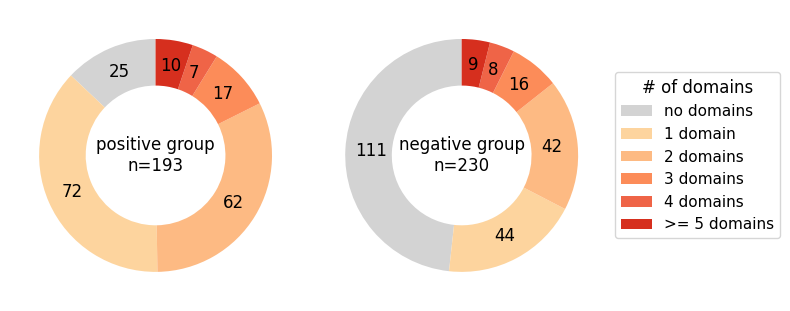

In [15]:
from matplotlib import colors
import matplotlib.pyplot as plt

# Function to conditionally display absolute numbers
def conditional_autopct(pct, all_values):
    absolute = int(round(pct * sum(all_values) / 100.0))
    return f"{absolute}" if absolute > 1 else ""



custom_label_dict = {
    0: "no domains",
    1: "1 domain",
    2: "2 domains",
    3: "3 domains",
    4: "4 domains",
    "more than 4": ">= 5 domains"  # For grouped keys
}

# Preprocess the data for the positive group
data_pos = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"] == 'pos'].domains_number.value_counts().sort_index().groupby(lambda x: "more than 4" if x > 4 else x).sum()
custom_labels_pos = [custom_label_dict.get(label, label) for label in data_pos.index]

# Preprocess the data for the negative group
data_neg = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"] == 'neg'].domains_number.value_counts().sort_index().groupby(lambda x: "more than 4" if x > 4 else x).sum()
custom_labels_neg = [custom_label_dict.get(label, label) for label in data_neg.index]

# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

palette = sns.color_palette("OrRd", 7)
palette[0] = 'lightgrey'
# Donut chart for the positive group
wedges1, texts1, autotexts1 = axes[0].pie(
    data_pos.values,
    # labels=custom_labels_pos,
    colors=palette,
    # explode = [0.03]*len(data_pos),
    autopct=lambda pct: conditional_autopct(pct, data_pos.values),
    startangle=90,
    wedgeprops=dict(width=0.4)
)

pos_len= len(proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"].isin(["pos"])])
axes[0].text(0,0,f"positive group\nn={pos_len}",ha='center', va= 'center', fontsize=12)

# Adjust text positions for positive group
for autotext in autotexts1:
    autotext.set_position((autotext.get_position()[0] * 1.3, autotext.get_position()[1] * 1.3))  # Move outward
    autotext.set_fontsize(12)  # Optional: Adjust font size


# Donut chart for the negative group
wedges2, texts2, autotexts2 = axes[1].pie(
    data_neg.values,
    # labels=custom_labels_neg,
    colors=palette,
    # explode = [0.03]*len(data_pos),

    autopct=lambda pct: conditional_autopct(pct, data_neg.values),
    startangle=90,
    wedgeprops=dict(width=0.4)
)

neg_len= len(proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"].isin(["neg"])])
axes[1].text(0,0,f"negative group\nn={neg_len}",ha='center', va= 'center', fontsize=12)

# Adjust text positions for positive group
for autotext in autotexts2:
    autotext.set_position((autotext.get_position()[0] * 1.3, autotext.get_position()[1] * 1.3))  # Move outward
    autotext.set_fontsize(12)  # Optional: Adjust font size

# sorted_legend_handles = [
#     plt.Line2D([0], [0], color=color_mapping[cat], marker='o', linestyle='', markersize=10)
#     for cat in sorted_categories
# ]


# # Create a single shared legend
# handles = [plt.Line2D([0], [0], color=color_mapping[cat], marker='o', linestyle='', markersize=10) 
#            for cat in categories]
axes[1].legend(wedges1, custom_labels_pos, title="# of domains", loc="center left", bbox_to_anchor=(1, 0.5), fontsize = 11,  title_fontsize=12)


plt.tight_layout()

subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

plt.savefig(subfolder + "2_Donut.svg")
plt.show()

In [16]:
#domain enrichment
data_pos = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"] == 'pos']
data_pos = data_pos.explode("domains")

data_pos.reset_index(inplace=True, drop=True)
data_pos["domain_name"] = data_pos["domains"].apply(lambda x: x[2] if isinstance(x, tuple) else "no domain")
data_pos["GO_terms"] = data_pos["domain_name"].apply((lambda x: domain_GO_dict.get(x, 'no GO term')))
data_pos_nod = data_pos[data_pos["domain_name"] != "no domain"]
data_pos_nod

#domain enrichment
data_neg = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"] == 'neg']
data_neg = data_neg.explode("domains")

data_neg.reset_index(inplace=True, drop=True)
data_neg["domain_name"] = data_neg["domains"].apply(lambda x: x[2] if isinstance(x, tuple) else "no domain")
data_neg["GO_terms"] = data_neg["domain_name"].apply((lambda x: domain_GO_dict.get(x, 'no GO term')))
data_neg_nod = data_neg[data_neg["domain_name"] != "no domain"]
data_neg_nod

,proteins,num_of_IDR,structure_string,structure_string_old,num_domains,domains,IDR_bounds,Group,reduced_struct_string,reduced_struct_string_old,categ_reduced_struct_string_old,domains_number,domain_name,GO_terms
1,Q9ULH4,4,DDIDIIM,DDIDIII,3,"(242, 287, Cysteine-rich flanking region, C-te...","[(382, 424, IDR), (576, 602, IDR), (618, 654, ...",neg,DIDIM,DIDI,DIDI,3,"Cysteine-rich flanking region, C-terminal",no GO term
2,Q9ULH4,4,DDIDIIM,DDIDIII,3,"(420, 518, Fibronectin type III)","[(382, 424, IDR), (576, 602, IDR), (618, 654, ...",neg,DIDIM,DIDI,DIDI,3,Fibronectin type III,[GO:0005515]
3,Q9ULH4,4,DDIDIIM,DDIDIII,3,"(290, 376, Immunoglobulin I-set)","[(382, 424, IDR), (576, 602, IDR), (618, 654, ...",neg,DIDIM,DIDI,DIDI,3,Immunoglobulin I-set,no GO term
4,Q8N878,3,MDDDII,IDDDII,3,"(58, 119, FERM, N-terminal)","[(0, 40, MOTIF), (376, 400, IDR), (421, 464, I...",neg,MDI,IDI,IDI,3,"FERM, N-terminal",no GO term
5,Q8N878,3,MDDDII,IDDDII,3,"(271, 339, FERM, C-terminal PH-like domain)","[(0, 40, MOTIF), (376, 400, IDR), (421, 464, I...",neg,MDI,IDI,IDI,3,"FERM, C-terminal PH-like domain",no GO term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,P0DKV0,8,MDIDIIIIII,IDIDIIIIII,2,"(285, 606, SPATA31)","[(56, 92, MOTIF), (120, 249, IDR), (482, 510, ...",neg,MDIDI,IDIDI,more\ncomplex,2,SPATA31,no GO term
364,Q7L311,3,IIMD,IIID,1,"(383, 601, Armadillo repeat-containing domain)","[(67, 125, IDR), (159, 309, IDR), (334, 369, M...",neg,IMD,ID,ID,1,Armadillo repeat-containing domain,no GO term
365,Q13470,2,DDDMI,DDDII,3,"(116, 377, Protein kinase domain)","[(445, 493, MOTIF), (505, 579, IDR)]",neg,DMI,DI,DI,3,Protein kinase domain,"[GO:0004672, GO:0005524, GO:0006468]"
366,Q13470,2,DDDMI,DDDII,3,"(119, 374, Serine-threonine/tyrosine-protein k...","[(445, 493, MOTIF), (505, 579, IDR)]",neg,DMI,DI,DI,3,"Serine-threonine/tyrosine-protein kinase, cata...","[GO:0004672, GO:0006468]"


Ser-Thr/Tyr protein kinase
RNA recognition motif domain
Homeobox domain
Zinc finger C2H2-type
Zinc finger, PHD-finger
RBM1CTR
Helicase, C-terminal
DEAD/DEAH box helicase domain
K Homology domain, type 1
Zinc finger, CCCH-type
SET domain
Bromodomain
SAP domain


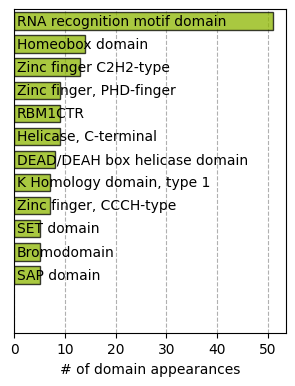

Protein kinase domain
EGF-like domain
Pleckstrin homology domain
EGF-like calcium-binding domain
Sterile alpha motif domain
Serine-threonine/tyrosine-protein kinase, catalytic domain
C2 domain
SH3 domain
Zinc finger, RING-type


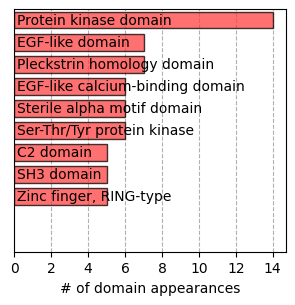

In [24]:
def simple_barplot(cdp, cdn, mode, min_apps=10, label_dict = dict()):
    if mode == 'positive':
        data_dict = cdp
        side_dict = cdn
        main_color = "#8DB600"
        side_color = '#FF4040'
    if mode == "negative":
        data_dict = cdn
        side_dict = cdp
        main_color = '#FF4040'
        side_color = "#8DB600"

    # keys = list(data_dict.keys())[:num_of_bars]
    # # print(keys)
    # # print(side_dict)
    # values = list(data_dict.values())[:num_of_bars]
    filtered_data = {key: value for key, value in data_dict.items() if value >= min_apps}
    keys = list(filtered_data.keys())
    values = list(filtered_data.values())
    side_values = {key: side_dict.get(key,0) for key in keys}.values()
    fig = plt.figure(figsize=(3.5, len(filtered_data.keys())*0.35))
    # Creating a bar plot
    # bars = plt.barh(keys, values, color = colorbase, alpha=0.7)

        
    # Create an offset for the secondary bars on the y-axis
    y_offset = 0.25  # Offset for the secondary bars (can be adjusted)
    thinner_height = 0.6  # Height of the secondary bars

    # Get y-tick positions for the main bars
    y_positions = np.arange(len(keys))

    # # Create a horizontal bar plot for the secondary bars (thinner) with a y-offset
    # plt.barh(y_positions + y_offset, side_values, color=side_color, edgecolor='black', 
    #         label='Secondary Values', height=thinner_height, alpha=0.5)

    # Create a horizontal bar plot for the main bars
    bars = plt.barh(keys, values, color = main_color, edgecolor='black', label='Main Values', height=0.75, alpha=0.75)

    # Set the y-tick labels back to categories
    # plt.xticks(rotation=90)
    
    # Remove x ticks at the bottom
    plt.yticks(ticks=[], labels=[])
    if mode == "negative":
        plt.xticks(ticks=range(0, 15, 2))
    # Annotate bars with x-values
    for bar, key in zip(bars, keys):
        print(key)
        # print(label_dict.get(key, key))
        plt.text(plt.gca().get_xlim()[1]*0.01,keys.index(key), label_dict.get(key, key), ha='left', va='center', rotation=0)
        # if key in label_dict:
            
        # else:
        #     plt.text(bar.get_y() + bar.get_width()/2, max_bar_height/50, key, ha='left', va='bottom', rotation=0)
    plt.xlabel('# of domain appearances')

    plt.gca().grid(axis='x', zorder=0, linestyle = '--')
    plt.gca().set_axisbelow(True)
    plt.gca().invert_yaxis()

    plt.ylim(len(keys)+1.5,-0.5)  # Add extra space below the bars
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

    plt.savefig(subfolder +  "2_domains_" + mode + ".svg", transparent=True)
    plt.show()


label_dict = {"Serine-threonine/tyrosine-protein kinase, catalytic domain": "Ser-Thr/Tyr protein kinase"}
print(label_dict["Serine-threonine/tyrosine-protein kinase, catalytic domain"])
data_pos_nod.domain_name.value_counts().to_dict()


simple_barplot(data_pos_nod.domain_name.value_counts().to_dict(), data_neg_nod.domain_name.value_counts().to_dict(), "positive", 5, label_dict)
simple_barplot(data_pos_nod.domain_name.value_counts().to_dict(), data_neg_nod.domain_name.value_counts().to_dict(), "negative", 5, label_dict)
# simple_barplot(cut_data, "negative", 10, '#FF4040', label_dict)

38
54


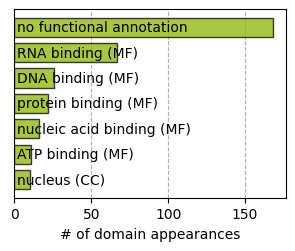

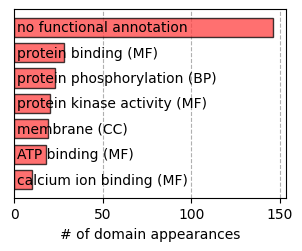

In [25]:
#### GO terms
data_pos_nog = data_pos_nod.explode("GO_terms")
# print(data_pos_nog.GO_terms.value_counts())
print(len(data_pos_nog.GO_terms.value_counts()))

data_neg_nog = data_neg_nod.explode("GO_terms")
# print(data_neg_nog.GO_terms.value_counts())
print(len(data_neg_nog.GO_terms.value_counts()))

def simple_barplot_GO(cdp, cdn, mode, min_apps=10, label_dict = dict()):
    if mode == 'positive':
        data_dict = cdp
        side_dict = cdn
        main_color = "#8DB600"
        side_color = '#FF4040'
    if mode == "negative":
        data_dict = cdn
        side_dict = cdp
        main_color = '#FF4040'
        side_color = "#8DB600"

    # keys = list(data_dict.keys())[:num_of_bars]
    # # print(keys)
    # # print(side_dict)
    # values = list(data_dict.values())[:num_of_bars]
    filtered_data = {key: value for key, value in data_dict.items() if value >= min_apps}
    keys = list(filtered_data.keys())
    values = list(filtered_data.values())
    # side_values = {key: side_dict.get(key,0) for key in keys}.values()
    fig = plt.figure(figsize=(3.5, len(filtered_data.keys())*0.35))
    # Creating a bar plot
    # bars = plt.barh(keys, values, color = colorbase, alpha=0.7)

        
    # Create an offset for the secondary bars on the y-axis
    y_offset = 0.25  # Offset for the secondary bars (can be adjusted)
    thinner_height = 0.6  # Height of the secondary bars

    # Get y-tick positions for the main bars
    y_positions = np.arange(len(keys))

    # # Create a horizontal bar plot for the secondary bars (thinner) with a y-offset
    # plt.barh(y_positions + y_offset, side_values, color=side_color, edgecolor='black', 
    #         label='Secondary Values', height=thinner_height, alpha=0.5)

    # Create a horizontal bar plot for the main bars
    bars = plt.barh(keys, values, color = main_color, edgecolor='black', label='Main Values', height=0.75, alpha=0.75)

    # Set the y-tick labels back to categories
    # plt.xticks(rotation=90)
    
    # Remove x ticks at the bottom
    plt.yticks(ticks=[], labels=[])
    # if mode == "negative":
    #     plt.xticks(ticks=range(0, 15, 2))
    # Annotate bars with x-values
    for bar, key in zip(bars, keys):
        new_label = GO_ID_dict.get(key, key)
        # print(new_label)
        if new_label == "regulation of DNA-templated transcription":
            new_label = "reg. of DNA-templ. transcription"
        category = get_go_term_details(key)
        if category is None:
            new_label = "no functional annotation"
        elif category["namespace"] == "biological_process":
            new_label += " (BP)"
        elif category["namespace"] == "cellular_component":
            new_label+= " (CC)"
        elif category["namespace"] == "molecular_function":
            new_label+= " (MF)"
        plt.text(plt.gca().get_xlim()[1]*0.01,keys.index(key), new_label, ha='left', va='center', rotation=0)
    # for bar, key in zip(bars, keys):
    #     print(key)
    #     # print(label_dict.get(key, key))
    #     plt.text(plt.gca().get_xlim()[1]*0.01,keys.index(key), label_dict.get(key, key), ha='left', va='center', rotation=0)
    #     # if key in label_dict:
            
        # else:
        #     plt.text(bar.get_y() + bar.get_width()/2, max_bar_height/50, key, ha='left', va='bottom', rotation=0)
    plt.xlabel('# of domain appearances')

    plt.gca().grid(axis='x', zorder=0, linestyle = '--')
    plt.gca().set_axisbelow(True)
    plt.gca().invert_yaxis()

    # plt.ylim(len(keys)+1.5,-0.5)  # Add extra space below the bars
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

    plt.savefig(subfolder +  "2_GO_" + mode + ".svg", transparent=True)
    plt.show()




simple_barplot_GO(data_pos_nog.GO_terms.value_counts().to_dict(), data_neg_nog.GO_terms.value_counts().to_dict(), "positive", 10, label_dict)
simple_barplot_GO(data_pos_nog.GO_terms.value_counts().to_dict(), data_neg_nog.GO_terms.value_counts().to_dict(), "negative", 10, label_dict)
# simple_barplot(cut_data, "negative", 10, '#FF4040', label_dict)

In [20]:
# for all  domain types (ten most frequent domain types in pos and neg) calculate the distance to the motif, in plus to the right and neg to the left 
# quasi its where is domain located from the perspective of the motif
# then filter for most important domain types (just go by number)
# but also create a "all", whcihc is the distances for all domains of the positive or negative group

In [ ]:
### notes

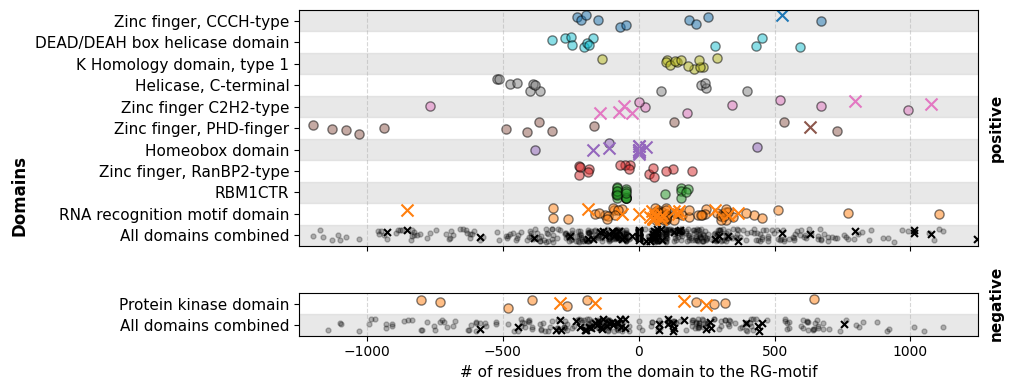

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def plot_motif_distances(df, motif_info_df, domain_GO_dict,view_limit, label_dict={}, show_singular_domains=False):
    # Determine height ratios based on the number of y-ticks
    y_tick_counts = []
    data_over = {}
    for group_label in ["pos", "neg"]:
        data_over[group_label] = {}
        filtered_df = df[df["Group"] == group_label].explode("domains").dropna(subset=['domains']).reset_index(drop=True)
        domains_to_check = set(filtered_df['domains'].apply(lambda x: x[2]))
        domain_motif_distances = {dom: ([], []) for dom in domains_to_check}
        for domain in domains_to_check:
            curr_protein_df = filtered_df[filtered_df["domains"].apply(lambda x: x[2] == domain)]
            for _, row in curr_protein_df.iterrows():
                curr_protein_id = row["proteins"]
                motif_count = len(motif_info_df[motif_info_df["UniqueID"] == curr_protein_id])
                domain_count = len(filtered_df[filtered_df["proteins"] == curr_protein_id])          #### use this if to chck for all domains
                # domain_count = len(curr_protein_df[curr_protein_df["proteins"] == curr_protein_id])  #### use this if only to check for same domains
                for _, motif_row in motif_info_df[motif_info_df["UniqueID"] == curr_protein_id].iterrows():
                    distance_abs = calculate_domain_motif_distance(row['domains'][:2], (motif_row["start"], motif_row["end"]),"c")
                    if domain_count == 1 and motif_count == 1:
                        domain_motif_distances[domain][1].append(distance_abs)
                    else:
                        domain_motif_distances[domain][0].append(distance_abs)
        zerolist = [domain_motif_distances[domain][0] for domain in domain_motif_distances.keys()]
        zerolist_GO1 = [domain_motif_distances[domain][0] for domain in domain_motif_distances.keys() if 'GO:0003723' in domain_GO_dict.get(domain, [])] # 'GO:0003723' RNA 
        zerolist_GO2 = [domain_motif_distances[domain][0] for domain in domain_motif_distances.keys() if 'GO:0003677' in domain_GO_dict.get(domain, [])] # 'GO:0003677' DNA
        zerolist_GO3 = [domain_motif_distances[domain][0] for domain in domain_motif_distances.keys() if 'GO:0005515' in domain_GO_dict.get(domain, [])] # 'GO:0005515' protein
        zerolist_GO4 = [domain_motif_distances[domain][0] for domain in domain_motif_distances.keys() if 'GO:0006468' in domain_GO_dict.get(domain, [])] # 'GO:0006468' phosphorylation

        onelist = [domain_motif_distances[domain][1] for domain in domain_motif_distances.keys()]
        onelist_GO1 = [domain_motif_distances[domain][1] for domain in domain_motif_distances.keys() if 'GO:0003723' in domain_GO_dict.get(domain, [])] # 'GO:0003723' RNA 
        onelist_GO2 = [domain_motif_distances[domain][1] for domain in domain_motif_distances.keys() if 'GO:0003677' in domain_GO_dict.get(domain, [])] # 'GO:0003677' DNA
        onelist_GO3 = [domain_motif_distances[domain][1] for domain in domain_motif_distances.keys() if 'GO:0005515' in domain_GO_dict.get(domain, [])] # 'GO:0005515' protein
        onelist_GO4 = [domain_motif_distances[domain][1] for domain in domain_motif_distances.keys() if 'GO:0006468' in domain_GO_dict.get(domain, [])] # 'GO:0006468' phosphorylation

        # print(zerolist)
        domain_motif_distances["All domains combined"] = ([item for sublist in zerolist for item in sublist], [item for sublist in onelist for item in sublist])
        # domain_motif_distances["RNA-binding"] = ([item for sublist in zerolist_GO1 for item in sublist], [item for sublist in onelist_GO1 for item in sublist])
        # domain_motif_distances["DNA-binding"] = ([item for sublist in zerolist_GO2 for item in sublist], [item for sublist in onelist_GO2 for item in sublist])
        # domain_motif_distances["protein-binding"] = ([item for sublist in zerolist_GO3 for item in sublist], [item for sublist in onelist_GO3 for item in sublist])
        # domain_motif_distances["protein-phosphorylation"] = ([item for sublist in zerolist_GO4 for item in sublist], [item for sublist in onelist_GO4 for item in sublist])

        domain_motif_distances_cut = {
            key: ([x for x in lst1 if abs(x) <= view_limit], [x for x in lst2 if abs(x) <= view_limit])
            for key, (lst1, lst2) in domain_motif_distances.items()
        }
        sorted_domains = sorted([(k, v[0] + v[1]) for k, v in domain_motif_distances_cut.items()], key=lambda v: len(v[1]), reverse=True)
        most_important_domains = [kyu for kyu, vyu in sorted_domains if len(domain_motif_distances_cut[kyu][0]) + len(domain_motif_distances_cut[kyu][1]) > 9]
        y_tick_counts.append(len(most_important_domains))
        data_over[group_label]["most_important_domains"] = most_important_domains
        data_over[group_label]["domain_motif_distances"] = domain_motif_distances

    height_ratios = [count / sum(y_tick_counts) for count in y_tick_counts]
    
    fig, axes = plt.subplots(2, 1, figsize=(10, sum(y_tick_counts)/3.25), sharex=True, gridspec_kw={'height_ratios': height_ratios})
    # sum(y_tick_counts)/2.5
    for ax, group_label, height_ratio in zip(axes, ["pos", "neg"], height_ratios):
        most_important_domains = data_over[group_label]["most_important_domains"]
        domain_motif_distances =  data_over[group_label]["domain_motif_distances"]
        domain_indices = {domain: idx for idx, domain in enumerate(most_important_domains)}
        for i in range(len(most_important_domains)):
            if i % 2 == 0:
                ax.axhspan(i - 0.5, i + 0.5, color='lightgrey', alpha=0.5)
        colors = plt.get_cmap("tab10").colors
        for idx, domain in enumerate(most_important_domains):
            if domain == "All domains combined":
                color = "black"
                dotsize= 50
                dotalpha = 0.25
                crosssize=25
            else:
                color = colors[idx % len(colors)]
                dotalpha = 0.5
                dotsize= 175
                crosssize=75
            domain_x_values = domain_motif_distances[domain][0]
            domain_y_values = [domain_indices[domain] + np.random.uniform(-0.30, 0.30) for _ in domain_x_values]
            ax.scatter(domain_x_values, domain_y_values, alpha=dotalpha, label=domain, color=color, s=dotsize, marker=".", edgecolor="black")
            if show_singular_domains:
                domain_special_x = domain_motif_distances[domain][1]
                domain_special_y = [domain_indices[domain] + np.random.uniform(-0.30, 0.30) for _ in domain_special_x]
                ax.scatter(domain_special_x, domain_special_y, marker='x', color=color, alpha=1.0, s=crosssize)
            else:
                domain_special_x = domain_motif_distances[domain][1]
                domain_special_y = [domain_indices[domain] + np.random.uniform(-0.30, 0.30) for _ in domain_special_x]
                ax.scatter(domain_special_x, domain_special_y, alpha=dotalpha, label=domain, color=color, s=dotsize, marker=".", edgecolor="black")
        # formatter = FuncFormatter(lambda val, pos: f'{(val**2) * np.sign(val):.0f}')
        # ax.xaxis.set_major_formatter(formatter)

        
        ax.set_yticks(list(domain_indices.values()))
        # print(list(domain_indices.keys()))
        ax.set_yticklabels([label_dict.get(x,x) for x in list(domain_indices.keys())], fontsize=11)
    
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)
        ax.set_xlim(-view_limit,view_limit)
        ax.set_ylim(-0.5, len(most_important_domains) - 0.5)
    axes[1].set_xlabel('# of residues from the domain to the RG-motif', fontsize=11)
    # axes[0].set_title(f'Scatter Plot of Motif Distances by Domain')
    axes[0].text(view_limit *1.03,y_tick_counts[0]//2, "positive", rotation=90, fontsize=11, fontweight="bold", va="center")
    axes[1].text(view_limit *1.03,y_tick_counts[1]//2, "negative", rotation=90, fontsize=11, fontweight="bold", va="center")
    # plt.xscale('symlog', linthresh=1)  # `linthresh` defines the linear range around zero
    plt.tight_layout()
    fig.text(-0.01, 0.5, "Domains", va='center', rotation='vertical', fontsize=12, fontweight="bold")
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

    plt.savefig(subfolder +  "2_domain_distances.svg", transparent=True)
    plt.show()
    # return filtered_df

y_label_dict = {'Serine-threonine/tyrosine-protein kinase, catalytic domain':"Ser-Thr/Tyr-protein kinase, catalytic"}

plot_motif_distances(proteins_with_domain_metrics_df, motif_info_set_df, domain_GO_dict,view_limit=1250, label_dict=y_label_dict, show_singular_domains=True)



In [123]:
dom_search = "K Homology domain, type 1"
# dom_search = "Zinc finger C2H2-type"

filtered_df = proteins_with_domain_metrics_df.explode("domains").dropna(subset=['domains']).reset_index(drop=True)[["proteins", "domains", "Group"]]

print(filtered_df[filtered_df["domains"].apply(lambda x: x[2] == dom_search)])

    proteins                                domains             Group
49    Q92945  (146, 209, K Homology domain, type 1)               pos
96    Q07666  (159, 207, K Homology domain, type 1)               pos
163   P51114  (221, 277, K Homology domain, type 1)               pos
194   Q96AE4  (102, 165, K Homology domain, type 1)               pos
444   O00425  (198, 261, K Homology domain, type 1)  Not in any group
552   Q06787  (221, 278, K Homology domain, type 1)               pos
716   Q5VWX1   (62, 117, K Homology domain, type 1)               pos
801   Q9NZI8  (198, 262, K Homology domain, type 1)  Not in any group
827   Q9NXZ2   (75, 129, K Homology domain, type 1)  Not in any group
870   P61978   (45, 104, K Homology domain, type 1)               pos


In [132]:
motif_info_set_df[motif_info_set_df["UniqueID"] == "P61978"]
# motif_info_set_df[motif_info_set_df["UniqueID"] == "]

,orig_motif_index,UniqueID,EntryName,motif,r_to_g_ratio,g_perc,r_perc,start,end,full_seq,...,IDR_overlap,IDR_position,PTM_names,PTM_distance,PTM_players,PTM_type,cur_llps_type,llps_pred_score,llps_pred_rank,source
1397,2028,P61978,HNRPK_HUMAN,MRGRGG,0.666667,50.000000,33.333333,255,260,METEQPEETFPNTETNGEFGKRPAEDMEEEQAFKRSRNTDEMVELR...,...,yes,0.772152,"[N-acetylmethionine, N6-acetyllysine, Phosphos...","[-254, -221, -219, -216, -180, -139, -57, -41,...","[[], [], [], [], [], [], [], [], [], [], [], [...","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",Client,0.811417,0.484323,HUMAN
1398,2029,P61978,HNRPK_HUMAN,GRGGRGG,0.400000,71.428571,28.571429,295,301,METEQPEETFPNTETNGEFGKRPAEDMEEEQAFKRSRNTDEMVELR...,...,yes,-0.240506,"[N-acetylmethionine, N6-acetyllysine, Phosphos...","[-294, -261, -259, -256, -220, -179, -97, -81,...","[[], [], [], [], [], [], [], [], [], [], [], [...","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",Client,0.811417,0.484323,HUMAN


In [ ]:
##### BACKUP

{'no GO term': 193, 'GO:0003723': 67, 'GO:0003677': 26, 'GO:0005515': 22, 'GO:0003676': 16, 'GO:0005524': 11, 'GO:0005634': 10, 'GO:0006355': 7, 'GO:0046872': 7, 'GO:0008270': 6, 'GO:0003700': 3, 'GO:0043565': 3, 'GO:0031124': 2, 'GO:0006396': 2, 'GO:0004386': 1, 'GO:0008168': 1, 'GO:0046983': 1, 'GO:0004402': 1, 'GO:0140658': 1, 'GO:0004525': 1, 'GO:0006334': 1, 'GO:0000786': 1, 'GO:0006306': 1, 'GO:0010468': 1, 'GO:0042054': 1, 'GO:0140673': 1, 'GO:0045893': 1, 'GO:0042254': 1, 'GO:0003724': 1, 'GO:0006354': 1, 'GO:0006413': 1, 'GO:0003743': 1, 'GO:0006397': 1, 'GO:0006364': 1, 'GO:0019843': 1, 'GO:0016567': 1, 'GO:0004842': 1, 'GO:0006606': 1}
{'no GO term': 257, 'GO:0005515': 28, 'GO:0006468': 23, 'GO:0004672': 20, 'GO:0016020': 19, 'GO:0005524': 18, 'GO:0005509': 10, 'GO:0003779': 6, 'GO:0007165': 6, 'GO:0008270': 4, 'GO:0005085': 3, 'GO:0004930': 3, 'GO:0006811': 2, 'GO:0008017': 2, 'GO:0030154': 2, 'GO:0006508': 2, 'GO:0004222': 2, 'GO:0015276': 2, 'GO:0055085': 2, 'GO:0018149':

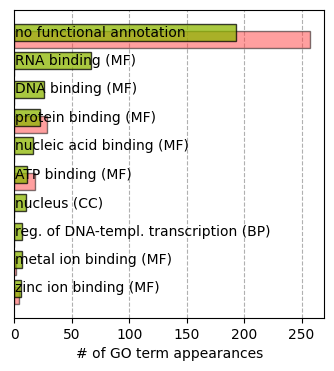

{'no GO term': 193, 'GO:0003723': 67, 'GO:0003677': 26, 'GO:0005515': 22, 'GO:0003676': 16, 'GO:0005524': 11, 'GO:0005634': 10, 'GO:0006355': 7, 'GO:0046872': 7, 'GO:0008270': 6, 'GO:0003700': 3, 'GO:0043565': 3, 'GO:0031124': 2, 'GO:0006396': 2, 'GO:0004386': 1, 'GO:0008168': 1, 'GO:0046983': 1, 'GO:0004402': 1, 'GO:0140658': 1, 'GO:0004525': 1, 'GO:0006334': 1, 'GO:0000786': 1, 'GO:0006306': 1, 'GO:0010468': 1, 'GO:0042054': 1, 'GO:0140673': 1, 'GO:0045893': 1, 'GO:0042254': 1, 'GO:0003724': 1, 'GO:0006354': 1, 'GO:0006413': 1, 'GO:0003743': 1, 'GO:0006397': 1, 'GO:0006364': 1, 'GO:0019843': 1, 'GO:0016567': 1, 'GO:0004842': 1, 'GO:0006606': 1}
{'no GO term': 257, 'GO:0005515': 28, 'GO:0006468': 23, 'GO:0004672': 20, 'GO:0016020': 19, 'GO:0005524': 18, 'GO:0005509': 10, 'GO:0003779': 6, 'GO:0007165': 6, 'GO:0008270': 4, 'GO:0005085': 3, 'GO:0004930': 3, 'GO:0006811': 2, 'GO:0008017': 2, 'GO:0030154': 2, 'GO:0006508': 2, 'GO:0004222': 2, 'GO:0015276': 2, 'GO:0055085': 2, 'GO:0018149':

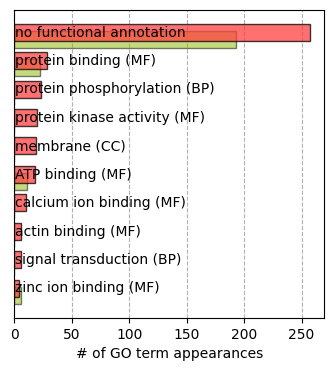

In [265]:
#GO term enrichment

cut_data = cut_data.explode("GO_terms")


# cut_data = cut_data.dropna(subset=["GO_terms"])
# cut_data = cut_data[cut_data["GO_terms"] != "Not Found"]
# cut_data[:20]

def simple_barplot(cut_data, mode, num_of_bars=10, colorbase = (0.125, 0.85, 0.45)):

    pos_data = cut_data[cut_data["Group"] == 'pos']
    neg_data = cut_data[cut_data["Group"] == 'neg']
    # print(pos_data)
    pos_occurences_dict = pos_data['GO_terms'].value_counts().to_dict()
    print(pos_occurences_dict)
    neg_occurences_dict = neg_data['GO_terms'].value_counts().to_dict()
    print(neg_occurences_dict)


    if mode == 'positive':
        data_dict = pos_occurences_dict
        side_dict = neg_occurences_dict
        main_color = "#8DB600"
        side_color = '#FF4040'
    if mode == "negative":
        data_dict = neg_occurences_dict
        side_dict = pos_occurences_dict
        main_color = '#FF4040'
        side_color = "#8DB600"

    keys = list(data_dict.keys())[:num_of_bars]
    print(keys)
    print(side_dict)
    values = list(data_dict.values())[:num_of_bars]
    side_values = {key: side_dict.get(key,0) for key in keys}.values()
    fig = plt.figure(figsize=(4, 4))
    # Creating a bar plot
    # bars = plt.barh(keys, values, color = colorbase, alpha=0.7)

        
    # Create an offset for the secondary bars on the y-axis
    y_offset = 0.25  # Offset for the secondary bars (can be adjusted)
    thinner_height = 0.6  # Height of the secondary bars

    # Get y-tick positions for the main bars
    y_positions = np.arange(len(keys))

    # Create a horizontal bar plot for the secondary bars (thinner) with a y-offset
    plt.barh(y_positions + y_offset, side_values, color=side_color, edgecolor='black', 
            label='Secondary Values', height=thinner_height, alpha=0.5)

    # Create a horizontal bar plot for the main bars
    bars = plt.barh(keys, values, color = main_color, edgecolor='black', label='Main Values', height=0.6, alpha=0.75)

    # Set the y-tick labels back to categories
    # plt.xticks(rotation=90)
    
    # Remove x ticks at the bottom
    plt.yticks(ticks=[], labels=[])
    plt.xticks()
    # Annotate bars with x-values

 

    for bar, key in zip(bars, keys):
        new_label = GO_ID_dict.get(key, key)
        print(new_label)
        if new_label == "regulation of DNA-templated transcription":
            new_label = "reg. of DNA-templ. transcription"
        category = get_go_term_details(key)
        if category is None:
            new_label = "no functional annotation"
        elif category["namespace"] == "biological_process":
            new_label += " (BP)"
        elif category["namespace"] == "cellular_component":
            new_label+= " (CC)"
        elif category["namespace"] == "molecular_function":
            new_label+= " (MF)"
        plt.text(0.5,keys.index(key), new_label, ha='left', va='center', rotation=0)
        # if key in label_dict:
            
        # else:
        #     plt.text(bar.get_y() + bar.get_width()/2, max_bar_height/50, key, ha='left', va='bottom', rotation=0)
    plt.xlabel('# of GO term appearances')

    plt.gca().grid(axis='x', zorder=0, linestyle = '--')
    plt.gca().set_axisbelow(True)
    plt.gca().invert_yaxis()
    plt.show()
# plt.yscale("log")


# print(GO_ID_dict)

# for key, values in GO_ID_dict.items():
#     category = get_go_term_details(key)  # Call the function with the key
#     if category["namespace"] == "biological_process":
#         stringadd = "(BP)"
#     elif category["namespace"] == "cellular_component":
#         stringadd = "(CC)"
#     elif category["namespace"] == "molecular_function":
#         stringadd = "(MF)"
#     updated_values = [f"{v} {stringadd}" for v in values]  # Add the category to each value
#     GO_ID_dict[key] = updated_values  # Update the dictionary


# label_dict = GO_ID_dict
# Example usage
# go_id = "GO:0008150"
# details = get_go_term_details(go_id)
# print(details["namespace"])


simple_barplot(cut_data, "positive", 10, "#8DB600")
simple_barplot(cut_data, "negative", 10, '#FF4040')

In [ ]:
#### how far are the motifs from the domains??
# for each protein check the distance between the motif and any motif



In [65]:
data_dict = cut_data

# for each domain count the occurences in each protein so i have a value for each protein
# do t_test
# first for the first 10 ones


statistics_dict = {}
for dom in domains_to_check:
    list1, list2 = [], []
    statistics_dict[dom] = []
    for posprot in pos_prot_list:
        temp_data = data_dict[data_dict["proteins"] == posprot]
        temp_list = temp_data["domain_name"].tolist()
        list1.append(temp_list.count(dom))
    # print(list1)
    for negprot in neg_prot_list:
        temp_data = data_dict[data_dict["proteins"] == negprot]
        temp_list = temp_data["domain_name"].tolist()
        list2.append(temp_list.count(dom))
    t_stat, p_value = ttest_ind(list1, list2)
    statistics_dict[dom].append(t_stat)
    statistics_dict[dom].append(p_value)
    statistics_dict[dom].append(p_value*len(domains_to_check))
    # statistics_dict[given_metric][aa].append(p_value)
    # statistics_dict[given_metric][aa].append(p_value*20)
# print(statistics_dict)
statistics_list = []
for key, value in statistics_dict.items():
    statistics_list.append((key, value[0], value[1], value[2]))
#     print(f"{key}: {value}")
pos_enriched_domains = list(sorted([x for x in statistics_list if str(x[3]) != 'nan' and x[1] > 0], key=lambda x: x[3]))
# newnewlist = list(sorted([x for x in statistics_list if str(x[3]) != 'nan' and x[1]>0], key=lambda x: x[3]))
for i in range(10):
    print(pos_enriched_domains[i])

neg_enriched_domains = list(sorted([x for x in statistics_list if str(x[3]) != 'nan' and x[1] < 0], key=lambda x: x[3]))
for i in range(10):
    print(neg_enriched_domains[i])


('RNA recognition motif domain', 8.531608271643178, 8.171817918482125e-17, 4.167627138425883e-15)
('Homeobox domain', 4.2036646731999285, 2.9489286492546102e-05, 0.0015039536111198513)
('DEAD/DEAH box helicase domain', 3.1482936237972226, 0.0017084812475999494, 0.08713254362759743)
('Zinc finger, CCCH-type', 2.9404525799239125, 0.0033799305758737963, 0.1723764593695636)
('Myc-type, basic helix-loop-helix (bHLH) domain', 1.1013286055320313, 0.2711132140763827, 13.826773917895519)
('Basic-leucine zipper domain', 1.101328605532031, 0.2711132140763829, 13.826773917895528)
('BTB/POZ domain', 0.7480062173860769, 0.4546950194887669, 23.189445993927112)
('SPRY domain', 0.7480062173860769, 0.4546950194887669, 23.189445993927112)


IndexError: list index out of range

In [64]:
from matplotlib.colors import LinearSegmentedColormap

def GO_term_barplot(domain_data, colorbase = (0.15, 0.75, 0.35)):
    # Extracting values for plotting and annotation
    # print(domain_data)
    labels = [item[0] for item in domain_data]  # First value in the tuple for annotation
    values = [item[3] for item in domain_data]  # Fourth value in the tuple for horizontal bar plot

    negative_log_values = [-np.log10(value) for value in values if value < 0.25]
    if len(negative_log_values) == 0:
        print('No domains enriched/depleted')
        return 
    # print(negative_log_values)
    # Filter out labels for values greater than 0
    filtered_labels = [label for label, value in zip(labels, values) if value < 0.25]

    # Define a colormap with a darker gradient
    r,g,b = colorbase
    colors = [(r,g,b,  - i*0.1 + 0.9) if value > 2 else (0.6, 0.6, 0.6, 0.5) for i, value in enumerate(negative_log_values)]
    # print(colors)
    # cmap = LinearSegmentedColormap.from_list('custom', colors)

    # Sort the data based on negative logarithm values
    sorted_data = sorted(zip(filtered_labels, negative_log_values, colors), key=lambda x: x[1])

    # Unzip sorted data
    sorted_labels, sorted_negative_log_values, sorted_colors = zip(*sorted_data)
    fig = plt.figure(figsize=(5,len(negative_log_values)/2))
    # Create the bar plot with normal scale on the x-axis
    plt.barh(sorted_labels, sorted_negative_log_values, color=sorted_colors)

    # Add annotations to the bars
    for i, value in enumerate(negative_log_values):
        plt.annotate(str(sorted_labels[i]), xy=(0, i), xytext=(5, 0), textcoords='offset points', va='center')

    # Add labels and title
    # Remove y tick labels
    plt.yticks([])
    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', color='grey', alpha=0.5)
    plt.xlabel('-log(p-value)')

GO_term_barplot(pos_enriched_domains, (0.15, 0.75, 0.35))
GO_term_barplot(neg_enriched_domains, (0.75, 0.15, 0.35))


NameError: name 'pos_enriched_domains' is not defined

In [ ]:
############# MOUSE
# ('RNA recognition motif domain', 6.76577993127802, 2.7037047079332094e-11, 1.1571856149954137e-08)
# ('Zinc finger C2H2-type', 4.142188353510385, 3.838601444539116e-05, 0.016429214182627418)
# ('Helicase, C-terminal domain-like', 3.344403048031738, 0.0008663142659804465, 0.3707825058396311)
# ('DEAD/DEAH box helicase domain', 3.1482936237972226, 0.0017084812475999494, 0.7312299739727783)
# ('Zinc finger, CCCH-type', 2.4775708891919623, 0.01345109608135397, 5.757069122819499)
# ('K Homology domain, type 1', 2.4775708891919623, 0.01345109608135397, 5.757069122819499)
# ('SAP domain', 2.4775708891919623, 0.01345109608135397, 5.757069122819499)
# ('Homeobox domain', 1.9133114337438, 0.0560953623005625, 24.00881506464075)
# ('SET domain', 1.9133114337438, 0.0560953623005625, 24.00881506464075)
# ('Bromodomain', 1.9133114337438, 0.0560953623005625, 24.00881506464075)
# ('Protein kinase domain', -3.9360946042827933, 9.06610257442583e-05, 0.038802919018542555)
# ('PDZ domain', -2.040514873071495, 0.04165496053520132, 17.828323109066165)
# ('Pleckstrin homology domain', -1.8228148897994543, 0.06873644989492697, 29.419200555028745)
# ('Fibronectin type III', -1.8228148897994543, 0.06873644989492697, 29.419200555028745)
# ('C2 domain', -1.8228148897994543, 0.06873644989492697, 29.419200555028745)
# ('EGF-like domain', -1.5766393405862253, 0.11530765105929017, 49.35167465337619)
# ('SH3 domain', -1.5766393405862253, 0.11530765105929017, 49.35167465337619)
# ('Serine-threonine/tyrosine-protein kinase, catalytic domain', -1.5766393405862253, 0.11530765105929017, 49.35167465337619)
# ('Rho GTPase-activating protein domain', -1.5766393405862253, 0.11530765105929017, 49.35167465337619)
# ('FERM central domain', -1.5766393405862253, 0.11530765105929017, 49.35167465337619)
# ____
# ('GO:0003723', 7.792848906904549, 2.2314753939503183e-14, 1.711541627159894e-11)
# ('GO:0003676', 4.0444381312055535, 5.797596074601843e-05, 0.04446756189219614)
# ('GO:0003677', 3.344403048031737, 0.0008663142659804506, 0.6644630420070057)
# ('GO:0006355', 1.9133114337438, 0.0560953623005625, 43.02514288453144)
# ('GO:0046872', 1.8866669094239101, 0.05959799040766452, 45.711658642678685)
# ('GO:0006397', 1.5598577403121012, 0.11922278427459627, 91.44387553861534)
# ('GO:0031124', 1.5598577403121012, 0.11922278427459627, 91.44387553861534)
# ('GO:0006396', 1.5598577403121012, 0.11922278427459627, 91.44387553861534)
# ('GO:0005634', 1.2004925041089982, 0.23033383563618806, 176.66605193295624)
# ('GO:0003735', 1.1013286055320313, 0.2711132140763827, 207.94383519658555)
# ('GO:0004672', -3.7413946676720156, 0.0001972217418820184, 0.15126907602350811)
# ('GO:0006468', -3.5934359695176923, 0.00034804958914897663, 0.2669540348772651)
# ('GO:0016020', -2.8987928205855162, 0.003857307133105387, 2.958554571091832)
# ('GO:0007165', -2.1304579004803372, 0.033464345364263806, 25.667152894390338)
# ('GO:0003779', -1.5766393405862253, 0.11530765105929017, 88.44096836247556)
# ('GO:0005085', -1.5766393405862251, 0.11530765105929025, 88.44096836247562)
# ('GO:0004930', -1.4858539275911515, 0.13774538402073042, 105.65070954390023)
# ('GO:0005524', -1.470831663534907, 0.14176345432258475, 108.7325694654225)
# ('GO:0005515', -1.3038248130962973, 0.1927004127777211, 147.80121660051208)
# ('GO:0004843', -1.2857224669134273, 0.19894376164192032, 152.5898651793529)


In [ ]:
# ################## HUMAN
# ('RNA recognition motif domain', 8.531608271643178, 8.171817918482125e-17, 3.4975380691103493e-14)
# ('Homeobox domain', 4.2036646731999285, 2.9489286492546102e-05, 0.012621414618809732)
# ('Helicase, C-terminal', 3.344403048031737, 0.0008663142659804506, 0.37078250583963285)
# ('Zinc finger C2H2-type', 3.279736816151621, 0.001087872399231851, 0.46560938687123227)
# ('DEAD/DEAH box helicase domain', 3.1482936237972226, 0.0017084812475999494, 0.7312299739727783)
# ('Zinc finger, CCCH-type', 2.9404525799239125, 0.0033799305758737963, 1.4466102864739847)
# ('K Homology domain, type 1', 2.940452579923913, 0.0033799305758737963, 1.4466102864739847)
# ('SET domain', 2.4775708891919623, 0.01345109608135397, 5.757069122819499)
# ('Bromodomain', 2.4775708891919623, 0.01345109608135397, 5.757069122819499)
# ('SAP domain', 2.4775708891919623, 0.01345109608135397, 5.757069122819499)
# ('Protein kinase domain', -3.4535074505094143, 0.0005849643729621552, 0.2503647516278024)
# ('Pleckstrin homology domain', -2.4204284113745893, 0.015742977535350373, 6.7379943851299595)
# ('EGF-like domain', -2.4204284113745893, 0.015742977535350373, 6.7379943851299595)
# ('Serine-threonine/tyrosine-protein kinase, catalytic domain', -2.2380713897315734, 0.02551432616892944, 10.9201316003018)
# ('EGF-like calcium-binding domain', -2.238071389731573, 0.025514326168929454, 10.920131600301806)
# ('SH3 domain', -2.0405148730714946, 0.04165496053520137, 17.828323109066186)
# ('C2 domain', -2.0405148730714946, 0.04165496053520137, 17.828323109066186)
# ('PDZ domain', -1.8228148897994543, 0.06873644989492697, 29.419200555028745)
# ('Laminin-type EGF domain', -1.8228148897994543, 0.06873644989492697, 29.419200555028745)
# ('Sterile alpha motif domain', -1.6518834350706972, 0.09898427284888052, 42.365268779320864)
# ____
# ('GO:0003723', 9.711373664771207, 4.6252467343931365e-21, 3.547564245279536e-18)
# ('GO:0003677', 5.40562568425852, 8.729761525994991e-08, 6.695727090438159e-05)
# ('GO:0003676', 4.508016196038395, 7.6097023592996455e-06, 0.005836641709582828)
# ('GO:0005634', 2.9709546900927233, 0.003065294382715467, 2.3510807915427634)
# ('GO:0006355', 2.9404525799239125, 0.0033799305758737963, 2.5924067516952016)
# ('GO:0046872', 2.4236329211543564, 0.015605876624866555, 11.969707371272648)
# ('GO:0003700', 1.9133114337438, 0.0560953623005625, 43.02514288453144)
# ('GO:0043565', 1.9133114337438, 0.0560953623005625, 43.02514288453144)
# ('GO:0031124', 1.5598577403121012, 0.11922278427459627, 91.44387553861534)
# ('GO:0006396', 1.5598577403121012, 0.11922278427459627, 91.44387553861534)
# ('GO:0004672', -3.25701631551895, 0.001177449144941904, 0.9031034941704404)
# ('GO:0006468', -3.2303471893579325, 0.0012912876988516605, 0.9904176650192236)
# ('GO:0016020', -3.040884176197065, 0.0024424373107668654, 1.8733494173581857)
# ('GO:0005509', -2.4454408383115385, 0.014700494425722648, 11.275279224529271)
# ('GO:0007165', -2.238071389731573, 0.025514326168929454, 19.569488171568892)
# ('GO:0004930', -1.5766393405862253, 0.11530765105929017, 88.44096836247556)
# ('GO:0005085', -1.5766393405862253, 0.11530765105929017, 88.44096836247556)
# ('GO:0003779', -1.5766393405862247, 0.11530765105929039, 88.44096836247573)
# ('GO:0006811', -1.2857224669134273, 0.19894376164192032, 152.5898651793529)
# ('GO:0055085', -1.2857224669134273, 0.19894376164192032, 152.5898651793529)


In [ ]:
# ##################### MERGED
# ('RNA recognition motif domain', 11.742182490235335, 2.631232433844905e-29, 1.1261674816856194e-26)
# ('Zinc finger C2H2-type', 5.3742932153676515, 1.0323912439840142e-07, 4.418634524251581e-05)
# ('Homeobox domain', 4.654080232781014, 3.858635232282391e-06, 0.0016514958794168633)
# ('DEAD/DEAH box helicase domain', 4.508016196038395, 7.6097023592996455e-06, 0.0032569526097802485)
# ('Zinc finger, CCCH-type', 3.879731969780732, 0.00011393045978733493, 0.04876223678897935)
# ('K Homology domain, type 1', 3.879731969780732, 0.00011393045978733493, 0.04876223678897935)
# ('SAP domain', 3.530746450918926, 0.0004401507484939301, 0.18838452035540207)
# ('Helicase, C-terminal domain-like', 3.344403048031738, 0.0008663142659804465, 0.3707825058396311)
# ('Helicase, C-terminal', 3.344403048031737, 0.0008663142659804506, 0.37078250583963285)
# ('SET domain', 3.1482936237972226, 0.0017084812475999494, 0.7312299739727783)
# ('Protein kinase domain', -5.34570921742489, 1.202200598000167e-07, 5.1454185594407144e-05)
# ('Pleckstrin homology domain', -3.049530559512091, 0.002374074910517211, 1.0161040617013664)
# ('EGF-like domain', -2.9039304476888987, 0.0037952874793725053, 1.6243830411714322)
# ('PDZ domain', -2.7514296935580043, 0.006079301576033641, 2.6019410745423985)
# ('C2 domain', -2.7514296935580043, 0.006079301576033641, 2.6019410745423985)
# ('Serine-threonine/tyrosine-protein kinase, catalytic domain', -2.7514296935580043, 0.006079301576033641, 2.6019410745423985)
# ('SH3 domain', -2.590803638207591, 0.009764549588043446, 4.179227223682595)
# ('Fibronectin type III', -2.4204284113745893, 0.015742977535350373, 6.7379943851299595)
# ('Rho GTPase-activating protein domain', -2.238071389731573, 0.025514326168929454, 10.920131600301806)
# ('EGF-like calcium-binding domain', -2.238071389731573, 0.025514326168929454, 10.920131600301806)
# ____
# ('GO:0003723', 13.778486698258337, 1.3473023440052086e-38, 1.033380897851995e-35)
# ('GO:0003677', 6.472961371792846, 1.753197521191278e-10, 1.34470249875371e-07)
# ('GO:0003676', 6.197094454671248, 9.565321122060401e-10, 7.336601300620327e-07)
# ('GO:0006355', 3.530746450918926, 0.0004401507484939301, 0.3375956240948444)
# ('GO:0005634', 3.2013394260804833, 0.001426610034055364, 1.0942098961204643)
# ('GO:0046872', 3.091138411359676, 0.0020689969882429077, 1.5869206899823103)
# ('GO:0003700', 2.212646637419517, 0.0272277956760749, 20.88371928354945)
# ('GO:0031124', 2.212646637419517, 0.0272277956760749, 20.88371928354945)
# ('GO:0006396', 2.212646637419517, 0.0272277956760749, 20.88371928354945)
# ('GO:0006397', 1.9133114337438, 0.0560953623005625, 43.02514288453144)
# ('GO:0004672', -5.02059548385123, 6.465693784199158e-07, 0.0004959187132480754)
# ('GO:0006468', -4.890159789349073, 1.2375243846021125e-06, 0.0009491812029898203)
# ('GO:0016020', -4.257661047261139, 2.332855889363758e-05, 0.017893004671420024)
# ('GO:0007165', -3.0873181715632243, 0.0020954263120823843, 1.6071919813671887)
# ('GO:0005509', -2.601794720781712, 0.009459912785756107, 7.255753106674934)
# ('GO:0005085', -2.238071389731573, 0.025514326168929454, 19.569488171568892)
# ('GO:0004930', -2.1304579004803372, 0.033464345364263806, 25.667152894390338)
# ('GO:0003779', -2.121626338761231, 0.03420222849146445, 26.23310925295323)
# ('GO:0004674', -1.8228148897994543, 0.06873644989492697, 52.720857069408986)
# ('GO:0006811', -1.8228148897994543, 0.06873644989492697, 52.720857069408986)


423
['M' 'MDI' 'IM' 'MD' 'IMI' 'IMD' 'MRI' 'MI' 'RMI' 'RM' 'DM' 'DMI' 'RMD'
 'MID' 'DMR' 'MIM' 'DMD' 'DRM' 'IRM' 'DIM' 'RIM' 'IDM' 'MDM' 'MRD']
24
Chi-square statistic: 103.63412979876462
p-value: 3.2991352346275205e-12
The difference in composition is statistically significant.


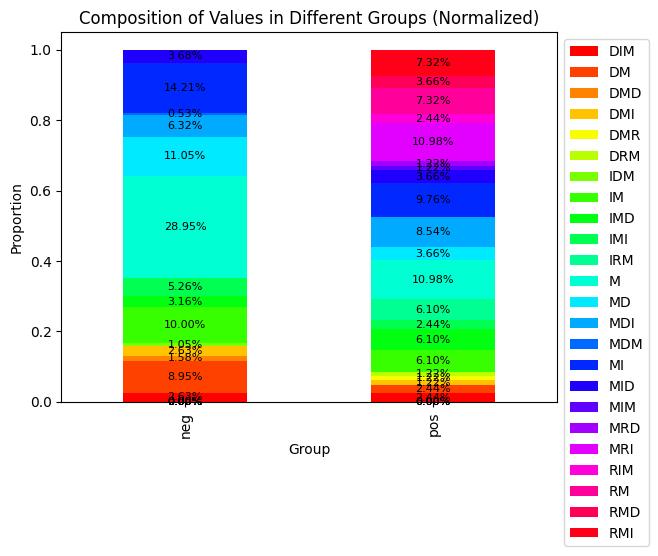

reduced_struct_string  DIM  DM  DMD  DMI  DMR  DRM  IDM  IM  IMD  IMI  ...  \
Group                                                                  ...   
neg                      5  17    3    5    0    0    2  19    6   10  ...   
pos                      2   2    0    1    1    1    0   5    5    2  ...   

reduced_struct_string  MDM  MI  MID  MIM  MRD  MRI  RIM  RM  RMD  RMI  
Group                                                                  
neg                      1  27    7    0    0    0    0   0    0    0  
pos                      0   8    3    1    1    9    2   6    3    6  

[2 rows x 24 columns]


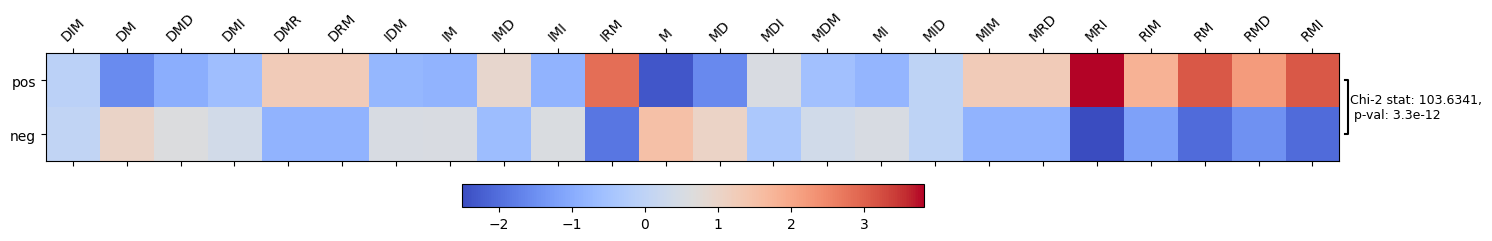

In [346]:
cut_data = proteins_with_domain_metrics_df[proteins_with_domain_metrics_df["Group"].isin(["pos", "neg"])]
cut_data.reset_index(inplace=True, drop=True)
print(len(cut_data))
cut_data = cut_data[cut_data["reduced_struct_string"].apply(lambda x: len(x) < 4)]
print(cut_data["reduced_struct_string"].unique())
print(len(cut_data["reduced_struct_string"].unique()))
plot_width = len(cut_data["reduced_struct_string"].unique())
# cut_data
# contingency_table = pd.crosstab(df['Group'], df['Category'])
contingency_table = pd.crosstab(cut_data['Group'], cut_data['reduced_struct_string'])


# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Display the results
print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')

# Determine statistical significance
alpha = 0.05
if p < alpha:
    print('The difference in composition is statistically significant.')
else:
    print('There is no significant difference in composition between the two groups.')

# Normalize the counts to have the same height for each group
normalized_count_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Plot a stacked bar chart with normalized heights
ax = normalized_count_table.plot(kind='bar', stacked=True, colormap='hsv')

# Add labels inside the stacked bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)


ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Add labels and title
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.title('Composition of Values in Different Groups (Normalized)')

# Show the plot
plt.show()
# Create a contingency table
# contingency_table = pd.crosstab(df['Group'], df['Category'])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(contingency_table)
# Calculate residuals
observed = contingency_table.values
expected = np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / contingency_table.sum().sum()
residuals = (observed - expected) / np.sqrt(expected)

# Visualize residuals
fig= plt.figure(figsize=(20,2))
ax = fig.gca()
cax = ax.matshow(residuals, cmap='coolwarm')
# plt.colorbar(cax)
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', pad=0.15)  # adjust pad as needed

ax.set_xlim(-0.5, residuals.shape[1] - 0.5)
ax.set_ylim(-0.5, residuals.shape[0] - 0.5)

ax.set_xticks(np.arange(len(contingency_table.columns)))
ax.set_xticklabels(contingency_table.columns, rotation=45)
ax.set_yticks(np.arange(len(contingency_table.index)))
ax.set_yticklabels(contingency_table.index)
# ax.yaxis.tick_right()
x = plot_width - 0.4
y1, y2, h, col = 0,1, 0.06, 'k'
ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1.5, c=col, clip_on=False)
ax.text(x+0.1, (y1+y2)*.5, ("Chi-2 stat: %.4f,\n p-val: %.1e" % (chi2, p)), ha='left', va='center', color=col, size=9)

# Add labels and title
plt.xlabel('')
# plt.ylabel('Group')
# plt.title('Chi-square Test Residuals')
# plt.xticks(size=15)


# Show the plot
plt.show()


In [81]:
chi2, p

(93.74432878998942, 5.102944427539064e-09)

In [ ]:
#### what i see is tha mostly the moitf wants to be c terminal from the domain

# 0. build categories based on that
# just quick idea:
##### 1. Domain left of motif

# 1. filter for only NA binding domains
# 2. and of course like everything split the PS and the NA binding property!


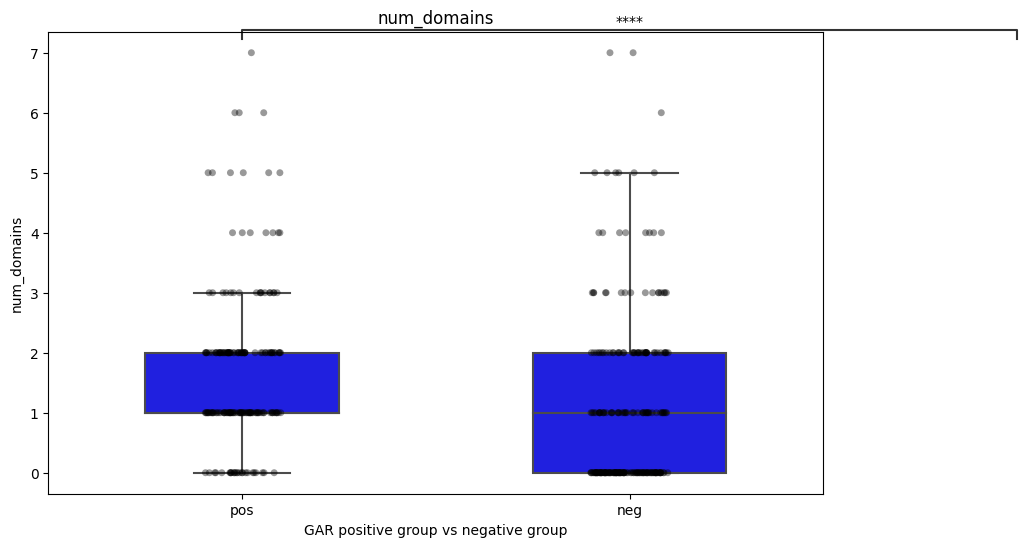

In [347]:
### number of structured domains?
from statannot import add_stat_annotation

def create_boxplot_with_dots(data, metric, list1, list2,outlierlim, ylimit=0):
    # data_list1 = [data[protein]['num_of_IDR'] for protein in list1]
    # data_list2 = [data[protein]['num_of_IDR'] for protein in list2]
    # print(data_list1)
    # Restructure the original data into a DataFrame
    df = pd.DataFrame(data).transpose()
    # print(df)
    # Define two groups of proteins

    # pos_prot_list = set_list[set_names.index("GAR_pos")]
    # neg_prot_list
    df.reset_index(inplace=True)
    df = df.rename(columns = {'index':'proteins'})
    df['Group'] = df['proteins'].apply(assign_group, args= (list1, "pos", list2, "neg"))
    df[metric] = pd.to_numeric(df[metric])
    # df["num_of_IDR_regions_w_motif"] = pd.to_numeric(df["num_of_IDR_regions_w_motif"])
    # df["num_of_IDR_regions_wo_motif"] = pd.to_numeric(df["num_of_IDR_regions_wo_motif"])
    # df["num_domains"] = pd.to_numeric(df["num_domains"])
    # print(df)
    # print(df.dtypes)

    # Create boxplots for the two groups
    plt.figure(figsize=(10, 6))
    if ylimit !=0:
        plt.ylim(0,ylimit)
    # sns.boxplot(data=df, y=metric, x='Group', color='blue', width=0.5, showfliers = False, order=["pos", "neg"])
    sns.boxplot(data=df, y=metric, x='Group', color='blue', width=0.5, showfliers = False, order=["pos", "neg"])
    sns.stripplot(data=df, y=metric, x='Group', color='black', size=5, jitter=True, alpha=0.4, order=["pos", "neg"])
    a = add_stat_annotation(plt.gca(),  data=df,
                                            x="Group",
                                            y=metric,
                                            box_pairs=[("pos", "neg")], #labels
                                            test='t-test_ind',
                                            text_format='star',
                                            verbose=0,
                                            loc='outside'
                                            )

    # plt.title("GAR positive group vs negative group")
    # month_q1 = df.groupby(df.index.Group).quantile(0.25)[metric].to_numpy()
    # month_q3 = df.groupby(df.index.Group).quantile(0.75)[metric].to_numpy()
    # print(month_q1, month_q3)
    # outlier_top_lim = month_q3 + 1.5 * (month_q3 - month_q1)
    # outlier_bottom_lim = month_q1 - 1.5 * (month_q3 - month_q1)

    if type(outlierlim) == str:
        print(df[df["proteins"] == outlierlim]["Group"].tolist()[0])
        if df[df["proteins"] == outlierlim]["Group"].tolist()[0] == "pos":
            x = 0
        else:
            x = 1
        val = df[df["proteins"] == outlierlim][metric].tolist()[0]
        plt.annotate(outlierlim, (x, val))
    elif outlierlim !=0:
        for i,row in df.iterrows():
            val = row[metric]
            # print(val)
            # print(row["Group"])
            if row["Group"] == "pos":
                x = 0
            else:
                x = 1
            if val > outlierlim:
                plt.annotate(row["proteins"], (x, val))
                print(row["proteins"])


    plt.xlabel("GAR positive group vs negative group")
    plt.title(metric)
    plt.show()

# create_boxplot_with_dots(prot_IDR_domain_dict,"num_domains",pos_prot_list ,neg_prot_list, 10)
create_boxplot_with_dots(protein_dict_with_domain_metrics,"num_domains",pos_prot_list ,neg_prot_list, 10)



In [ ]:
### number o RGG and RG repeats in the motif/protrin
### maybe also check for these repeats and how close they are
# number of Rg and RGG occurences

In [ ]:
# charge of the motif
# charge profil of the motif IDR
# smae with polarity and same with aromaticity


In [354]:
## extract the group of proteins that ar RM vs the group that are MR and compare them in the distance of the motif to the R domain ()



motif_info_set_df

,orig_motif_index,UniqueID,EntryName,motif,r_to_g_ratio,g_perc,r_perc,start,end,full_seq,...,IDR_overlap,IDR_position,PTM_names,PTM_distance,PTM_players,PTM_type,cur_llps_type,llps_pred_score,llps_pred_rank,source
608,0,Q5SSQ6,SAPC1_HUMAN,QRGCTKGPRG,0.666667,30.000000,20.000000,135,144,MGSQGSGGVPLVQAPYTVLLLPLGTSRQDPGAQSFFLWLRRMQALE...,...,yes,-0.500000,[],[],[],[],None,0.121801,0.086503,HUMAN
609,2,Q7Z7L8,CK096_HUMAN,LRGRGFSRNPRGRGLPSGAGWRG,0.857143,30.434783,26.086957,146,168,MGNKQPQKVTVPTGTALQGVVLIVSTLHQPGGWICGKDPCCSLRPL...,...,yes,0.551020,"[Phosphothreonine, Phosphoserine, Phosphoserin...","[200, 217, 231, 241, 257, 263]","[[], [], [], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",None,0.754444,0.483994,HUMAN
610,4,Q8NAF0,ZN579_HUMAN,HRGRGRGRGRGRGRGRGRGRGG,0.909091,50.000000,45.454545,15,36,MDPQPPPPAQGSPPHRGRGRGRGRGRGRGRGRGRGGAGAPRAPLPC...,...,yes,-0.219512,"[Omega-N-methylarginine, Phosphoserine, Phosph...","[56, 158, 160, 447]","[[], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES]",None,0.389831,0.560056,HUMAN
611,6,Q9ULH4,LRFN2_HUMAN,GRGAGTSARG,0.500000,40.000000,20.000000,681,690,METLLGGLLAFGMAFAVVDACPKYCVCQNLSESLGTLCPSKGLLFV...,...,yes,-0.117647,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-652, -349, -340, -297, -371]","[[], [], [], [], []]","[CARBOHYD, CARBOHYD, CARBOHYD, CARBOHYD, DISUL...",None,0.078058,0.292100,HUMAN
612,10,Q8N878,FRMD1_HUMAN,PRGRG,1.000000,40.000000,40.000000,5,9,MAVPPRGRGIDPARTNPDTFPPSGARCMEPSPERPACSQQEPTLGM...,...,yes,0.684211,[],[],[],[],None,0.261972,0.259337,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2107,Q53GS9,SNUT2_HUMAN,SRGSTRGKRESESRG,1.333333,20.000000,26.666667,9,23,MSGRSKRESRGSTRGKRESESRGSSGRVKRERDREREPEAASSRGS...,...,yes,0.491525,"[Phosphoserine, Phosphoserine, Glycyl lysine i...","[23, 59, 28]","[[], [], []]","[MOD_RES, MOD_RES, CROSSLNK]",Client,0.534845,0.483784,HUMAN
1434,2114,Q13470,TNK1_HUMAN,HRGTPARG,1.000000,25.000000,25.000000,455,462,MLPEAGSLWLLKLLRDIQLAQFYWPILEELNVTRPEHFDFVKPEDL...,...,yes,0.404255,"[Phosphoserine, Phosphoserine, Phosphoserine, ...","[-395, -359, -200, 40, 52, 57, 120, -44]","[[], [], [], [], [], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",None,0.074419,0.463465,HUMAN
1435,2116,Q8N8E1,MAAS1_HUMAN,PRGRG,1.000000,40.000000,40.000000,30,34,MALSMSLSSDILSGAPTAGRGGGCSAALSPRGRGSKGLGTRAPGPR...,...,yes,0.205128,[],[],[],[],None,0.208760,0.410388,HUMAN
1436,2117,Q8NG27,PJA1_HUMAN,RRGRG,1.500000,40.000000,60.000000,306,310,MGQESSKPVWPNPTGGYQSNTGRRYGRRHAYVSFRPPTSQRERIAS...,...,yes,-0.700831,"[Phosphoserine, Phosphothreonine, Phosphoserin...","[-41, -29, 55, 57]","[[], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES]",Client,0.599737,0.822601,HUMAN


In [ ]:
#### addition 06Dec2024

# i want to check all domains for their aa compoistion, does the content of R get lower when i have a RG motif in my 

In [9]:
### here i find the raw dataframe of humans with all protiens and their seqs

human_proteome_sequences = pd.read_csv(r'/mnt/d/phd/scripts/0_motif_exploration/output/dataframe_of_humane_proteome.csv')
human_proteome_sequences

# for all domains, get the seq, calc the composition (just as a dict)
# then assign the groups (all, pos, neg)
# then plot

,sequences,description,db,UniqueIdentifier,EntryName,gene_name,Else,length,R%,G%,R%+G%,RtoG_ratio
0,XNRDDKIIFGKGTRLHILP,tr|A0A075B6Y1|A0A075B6Y1_HUMAN T cell receptor...,tr,A0A075B6Y1,A0A075B6Y1_HUMAN,TRAJ30,"{'A': 0, 'C': 0, 'D': 2, 'E': 0, 'F': 1, 'G': ...",19,10.526316,10.526316,21.052632,1.000
1,MCCNYYGNSCGYGSSYGCGYGSGYGCGYGSSYGCGYGSGYGCGYGS...,tr|A0A3B3IRS2|A0A3B3IRS2_HUMAN Keratin-associa...,tr,A0A3B3IRS2,A0A3B3IRS2_HUMAN,LOC647264,"{'A': 0, 'C': 18, 'D': 0, 'E': 0, 'F': 2, 'G':...",109,2.752294,36.697248,39.449541,0.075
2,MWTEEAGATAEAQESGIRNKSSSSSQIPVVGVVTEDDEAQDVFKPM...,sp|A5D8W1|CFA69_HUMAN Cilia- and flagella-asso...,sp,A5D8W1,CFA69_HUMAN,CFAP69,"{'A': 62, 'C': 22, 'D': 45, 'E': 74, 'F': 35, ...",941,2.975558,4.994687,7.970244,0.596
3,MEVNPPKQEHLLALKVMRLTKPTLFTNIPVTCEEKDLPGDLFNQLM...,sp|A5PLN9|TPC13_HUMAN Trafficking protein part...,sp,A5PLN9,TPC13_HUMAN,TRAPPC13,"{'A': 20, 'C': 12, 'D': 21, 'E': 28, 'F': 16, ...",417,3.357314,5.035971,8.393285,0.667
4,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,sp|A6NFQ2|TCAF2_HUMAN TRPM8 channel-associated...,sp,A6NFQ2,TCAF2_HUMAN,TCAF2,"{'A': 84, 'C': 25, 'D': 31, 'E': 54, 'F': 26, ...",919,4.570185,8.596300,13.166485,0.532
...,...,...,...,...,...,...,...,...,...,...,...,...
20575,MGDGGAERDRGPARRAESGGGGGRCGDRSGAGDLRADGGGHSPTEV...,sp|Q9UIW0|VAX2_HUMAN Ventral anterior homeobox...,sp,Q9UIW0,VAX2_HUMAN,VAX2,"{'A': 28, 'C': 5, 'D': 15, 'E': 18, 'F': 6, 'G...",290,10.689655,10.689655,21.379310,1.000
20576,MPQASEHRLGRTREPPVNIQPRVGSKLPFAPRARSKERRNPASGPN...,sp|Q9UK80|UBP21_HUMAN Ubiquitin carboxyl-termi...,sp,Q9UK80,UBP21_HUMAN,USP21,"{'A': 35, 'C': 15, 'D': 22, 'E': 30, 'F': 24, ...",565,10.619469,8.318584,18.938053,1.277
20577,MLRDTMKSWNDSQSDLCSTDQEEEEEMIFGENEDDLDEMMDLSDLP...,sp|Q9UKA8|RCAN3_HUMAN Calcipressin-3 OS=Homo s...,sp,Q9UKA8,RCAN3_HUMAN,RCAN3,"{'A': 17, 'C': 5, 'D': 17, 'E': 29, 'F': 13, '...",241,4.564315,2.904564,7.468880,1.571
20578,MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,sp|Q9UNL4|ING4_HUMAN Inhibitor of growth prote...,sp,Q9UNL4,ING4_HUMAN,ING4,"{'A': 16, 'C': 8, 'D': 19, 'E': 22, 'F': 8, 'G...",249,5.622490,4.819277,10.441767,1.167


In [11]:
import pandas as pd
from collections import Counter


human_pfam_annotated_domain_df = pfam_annotated_domain_df[pfam_annotated_domain_df['source'] == "human"]
# human_pfam_annotated_domain_df
rg_proteins_list = motif_info_set_df.UniqueID.tolist()

human_domains_composition_list= []


def calculate_aa_percentage(sequence):
    total_length = len(sequence)
    # print(sequence)
    # print(total_length)
    counts = Counter(sequence)
    percentages = {aa: (count / total_length) * 100 for aa, count in counts.items()}
    percentages["[RK]"] = ((counts["R"] + counts["K"]) / total_length) * 100
    percentages["[DE]"] = ((counts["D"] + counts["E"]) / total_length) * 100
    percentages["[YFW]"] = ((counts["Y"] + counts["F"] + counts["W"]) / total_length) * 100
    return percentages

def calculate_aa_counts(sequence):
    counts_counter = Counter(sequence)
    counts = {aa: count for aa, count in counts_counter.items()}
    counts["[RK]"] = counts.get("R", 0) + counts.get("K", 0)
    counts["[DE]"] = counts.get("D", 0) + counts.get("E",0)
    counts["[YFW]"] = counts.get("Y", 0) + counts.get("F", 0) + counts.get("W", 0)
    return counts

for i,r in human_pfam_annotated_domain_df.iterrows():

    if r["protein_name"] in pos_prot_list:
        group_temp = "pos"
    elif r["protein_name"] in neg_prot_list:
        group_temp = "neg"
    else: 
        group_temp = "other"

    full_sequence = human_proteome_sequences[human_proteome_sequences["UniqueIdentifier"] == r["protein_name"]].sequences.tolist()[0]
    # print(full_sequence)
    domain_sequence = full_sequence[r["start"]:r["end"]]
    rest_sequence = full_sequence[0:r["start"]] + full_sequence[r["end"]:len(full_sequence)]

    row = {     "prot": r["protein_name"], "domain_ID": r["accession"],
                "domain_name": r["name"], 'full_seq': full_sequence,
                "domain_coords": (r["start"]-1, r["end"]), "domain_seq": domain_sequence,
                "rest_seq": rest_sequence,
                "group": group_temp
           }
    if len(domain_sequence) == 0:
        continue
    human_domains_composition_list.append(row)

# row = {     "prot": "test", "domain_ID": "test",
#             "domain_name": "test", 'full_seq': "AAAAADDDDDFFFFFACCCCC",
#             "domain_coords": (5,10), "domain_seq": "DDDDDFFFFFA",
#             "group": "test"
#         }
# human_domains_composition_list.append(row)
human_domains_composition_df = pd.DataFrame(human_domains_composition_list)

# Apply the function to the DataFrame
human_domains_composition_df["aa_percentage"] = human_domains_composition_df["domain_seq"].apply(calculate_aa_percentage)
human_domains_composition_df["aa_percentage_rest"] = human_domains_composition_df["rest_seq"].apply(calculate_aa_percentage)
human_domains_composition_df["aa_counts"] = human_domains_composition_df["domain_seq"].apply(calculate_aa_counts)
human_domains_composition_df["aa_counts_rest"] = human_domains_composition_df["rest_seq"].apply(calculate_aa_counts)



human_domains_composition_df
# filter only humans
# create dataset of protein, domain, the sequence of full prot, region of domain, seq of domain, all ratios, group, 

,prot,domain_ID,domain_name,full_seq,domain_coords,domain_seq,rest_seq,group,aa_percentage,aa_percentage_rest,aa_counts,aa_counts_rest
0,A5D8W1,IPR048733,"Cilia- and flagella-associated protein 69, ARM...",MWTEEAGATAEAQESGIRNKSSSSSQIPVVGVVTEDDEAQDVFKPM...,"(45, 763)",DLNRVIKLLEETDKDGLEEKQLKFVKKLVQCYQNGLPLRDLAQIFK...,MWTEEAGATAEAQESGIRNKSSSSSQIPVVGVVTEDDEAQDVFKPM...,other,"{'D': 4.881450488145049, 'L': 13.9470013947001...","{'M': 1.7857142857142856, 'W': 0.8928571428571...","{'D': 35, 'L': 100, 'N': 34, 'R': 19, 'V': 37,...","{'M': 4, 'W': 2, 'T': 17, 'E': 18, 'A': 24, 'G..."
1,A6NFQ2,IPR031161,Peptidase family M60 domain,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,"(541, 889)",CWVSTGLYLLEGQNAEVSLSEAAASAGLRVQIGCHTDDLTKARKLS...,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,other,"{'C': 2.0172910662824206, 'W': 4.3227665706051...","{'M': 1.2237762237762237, 'A': 9.7902097902097...","{'C': 7, 'W': 15, 'V': 25, 'S': 17, 'T': 20, '...","{'M': 7, 'A': 56, 'T': 19, 'I': 22, 'F': 17, '..."
2,A6NFQ2,IPR035423,"M60-like domain, N-terminal",MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,"(523, 632)",SKHPITVEINGINPGNNDCWVSTGLYLLEGQNAEVSLSEAAASAGL...,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,other,"{'S': 8.333333333333332, 'K': 3.70370370370370...","{'M': 1.8495684340320593, 'A': 9.4944512946979...","{'S': 9, 'K': 4, 'H': 3, 'P': 6, 'I': 6, 'T': ...","{'M': 15, 'A': 77, 'T': 32, 'I': 29, 'F': 26, ..."
3,M0R2J8,IPR000772,"Ricin B, lectin domain",MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,"(1162, 1263)",HQQFEYRDGQIISHAAPQLVLGVQGPNLRSGMEVVLVEKKSDGSHQ...,MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,other,"{'H': 5.0, 'Q': 9.0, 'F': 2.0, 'E': 5.0, 'Y': ...","{'M': 2.3172905525846703, 'A': 6.2388591800356...","{'H': 5, 'Q': 9, 'F': 2, 'E': 5, 'Y': 4, 'R': ...","{'M': 39, 'A': 105, 'K': 145, 'T': 96, 'G': 94..."
4,M0R2J8,IPR003533,Doublecortin domain,MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,"(178, 246)",KNGSRTVFARVTVPTITLLLEECTEKLNLNMAARRVFLADGKEALE...,MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,other,"{'K': 4.477611940298507, 'N': 5.97014925373134...","{'M': 2.331002331002331, 'A': 6.06060606060606...","{'K': 3, 'N': 4, 'G': 3, 'S': 2, 'R': 4, 'T': ...","{'M': 40, 'A': 104, 'K': 148, 'T': 93, 'G': 98..."
...,...,...,...,...,...,...,...,...,...,...,...,...
24834,Q9UIW0,IPR001356,Homeobox domain,MGDGGAERDRGPARRAESGGGGGRCGDRSGAGDLRADGGGHSPTEV...,"(99, 164)",RPKRTRTSFTAEQLYRLEMEFQRCQYVVGRERTELARQLNLSETQV...,MGDGGAERDRGPARRAESGGGGGRCGDRSGAGDLRADGGGHSPTEV...,other,"{'R': 17.1875, 'P': 1.5625, 'K': 7.8125, 'T': ...","{'M': 0.4424778761061947, 'G': 13.274336283185...","{'R': 11, 'P': 1, 'K': 5, 'T': 6, 'S': 3, 'F':...","{'M': 1, 'G': 30, 'D': 13, 'A': 26, 'E': 12, '..."
24835,Q9UK80,IPR001394,"Peptidase C19, ubiquitin carboxyl-terminal hyd...",MPQASEHRLGRTREPPVNIQPRVGSKLPFAPRARSKERRNPASGPN...,"(211, 555)",GLRNLGNTCFLNAVLQCLSSTRPLRDFCLRRDFRQEVPGGGRAQEL...,MPQASEHRLGRTREPPVNIQPRVGSKLPFAPRARSKERRNPASGPN...,other,"{'G': 6.997084548104956, 'L': 11.3702623906705...","{'M': 2.7027027027027026, 'P': 16.216216216216...","{'G': 24, 'L': 39, 'R': 31, 'N': 13, 'T': 12, ...","{'M': 6, 'P': 36, 'Q': 4, 'A': 14, 'S': 22, 'E..."
24836,Q9UNL4,IPR019787,"Zinc finger, PHD-finger",MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,"(195, 245)",TYCLCHQVSYGEMIGCDNPDCSIEWFHFACVGLTTKPRGKWFCPRCSQE,MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,other,"{'T': 6.122448979591836, 'Y': 4.08163265306122...","{'M': 4.0, 'A': 7.5, 'G': 4.0, 'Y': 3.50000000...","{'T': 3, 'Y': 2, 'C': 7, 'L': 2, 'H': 2, 'Q': ...","{'M': 8, 'A': 15, 'G': 8, 'Y': 7, 'L': 19, 'E'..."
24837,Q9UNL4,IPR024610,"Inhibitor of growth protein, N-terminal histon...",MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,"(5, 107)",LEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLATEYMSS...,MAAGMYEADLKEKQIESSDYDSSSSKGKKKGRTQKEKKAARARSKG...,other,"{'L': 14.85148514851485, 'E': 10.8910891089108...","{'M': 3.3783783783783785, 'A': 6.0810810810810...","{'L': 15, 'E': 11, 'H': 2, 'Y': 4, 'D

In [12]:
human_domains_composition_df

,prot,domain_ID,domain_name,full_seq,domain_coords,domain_seq,rest_seq,group,aa_percentage,aa_percentage_rest,aa_counts,aa_counts_rest
0,A5D8W1,IPR048733,"Cilia- and flagella-associated protein 69, ARM...",MWTEEAGATAEAQESGIRNKSSSSSQIPVVGVVTEDDEAQDVFKPM...,"(45, 763)",DLNRVIKLLEETDKDGLEEKQLKFVKKLVQCYQNGLPLRDLAQIFK...,MWTEEAGATAEAQESGIRNKSSSSSQIPVVGVVTEDDEAQDVFKPM...,other,"{'D': 4.881450488145049, 'L': 13.9470013947001...","{'M': 1.7857142857142856, 'W': 0.8928571428571...","{'D': 35, 'L': 100, 'N': 34, 'R': 19, 'V': 37,...","{'M': 4, 'W': 2, 'T': 17, 'E': 18, 'A': 24, 'G..."
1,A6NFQ2,IPR031161,Peptidase family M60 domain,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,"(541, 889)",CWVSTGLYLLEGQNAEVSLSEAAASAGLRVQIGCHTDDLTKARKLS...,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,other,"{'C': 2.0172910662824206, 'W': 4.3227665706051...","{'M': 1.2237762237762237, 'A': 9.7902097902097...","{'C': 7, 'W': 15, 'V': 25, 'S': 17, 'T': 20, '...","{'M': 7, 'A': 56, 'T': 19, 'I': 22, 'F': 17, '..."
2,A6NFQ2,IPR035423,"M60-like domain, N-terminal",MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,"(523, 632)",SKHPITVEINGINPGNNDCWVSTGLYLLEGQNAEVSLSEAAASAGL...,MATIAAAAFEALMDGVTCWDVPRGPIPSELLLIGEAAFPVMVNDKG...,other,"{'S': 8.333333333333332, 'K': 3.70370370370370...","{'M': 1.8495684340320593, 'A': 9.4944512946979...","{'S': 9, 'K': 4, 'H': 3, 'P': 6, 'I': 6, 'T': ...","{'M': 15, 'A': 77, 'T': 32, 'I': 29, 'F': 26, ..."
3,M0R2J8,IPR000772,"Ricin B, lectin domain",MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,"(1162, 1263)",HQQFEYRDGQIISHAAPQLVLGVQGPNLRSGMEVVLVEKKSDGSHQ...,MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,other,"{'H': 5.0, 'Q': 9.0, 'F': 2.0, 'E': 5.0, 'Y': ...","{'M': 2.3172905525846703, 'A': 6.2388591800356...","{'H': 5, 'Q': 9, 'F': 2, 'E': 5, 'Y': 4, 'R': ...","{'M': 39, 'A': 105, 'K': 145, 'T': 96, 'G': 94..."
4,M0R2J8,IPR003533,Doublecortin domain,MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,"(178, 246)",KNGSRTVFARVTVPTITLLLEECTEKLNLNMAARRVFLADGKEALE...,MAKTGAEDHREALSQSSLSLLTEAMEVLQQSSPEGTLDGNTVNPIY...,other,"{'K': 4.477611940298507, 'N': 5.97014925373134...","{'M': 2.331002331002331, 'A': 6.06060606060606...","{'K': 3, 'N': 4, 'G': 3, 'S': 2, 'R': 4, 'T': ...","{'M': 40, 'A': 104, 'K': 148, 'T': 93, 'G': 98..."
...,...,...,...,...,...,...,...,...,...,...,...,...
24834,Q9UIW0,IPR001356,Homeobox domain,MGDGGAERDRGPARRAESGGGGGRCGDRSGAGDLRADGGGHSPTEV...,"(99, 164)",RPKRTRTSFTAEQLYRLEMEFQRCQYVVGRERTELARQLNLSETQV...,MGDGGAERDRGPARRAESGGGGGRCGDRSGAGDLRADGGGHSPTEV...,other,"{'R': 17.1875, 'P': 1.5625, 'K': 7.8125, 'T': ...","{'M': 0.4424778761061947, 'G': 13.274336283185...","{'R': 11, 'P': 1, 'K': 5, 'T': 6, 'S': 3, 'F':...","{'M': 1, 'G': 30, 'D': 13, 'A': 26, 'E': 12, '..."
24835,Q9UK80,IPR001394,"Peptidase C19, ubiquitin carboxyl-terminal hyd...",MPQASEHRLGRTREPPVNIQPRVGSKLPFAPRARSKERRNPASGPN...,"(211, 555)",GLRNLGNTCFLNAVLQCLSSTRPLRDFCLRRDFRQEVPGGGRAQEL...,MPQASEHRLGRTREPPVNIQPRVGSKLPFAPRARSKERRNPASGPN...,other,"{'G': 6.997084548104956, 'L': 11.3702623906705...","{'M': 2.7027027027027026, 'P': 16.216216216216...","{'G': 24, 'L': 39, 'R': 31, 'N': 13, 'T': 12, ...","{'M': 6, 'P': 36, 'Q': 4, 'A': 14, 'S': 22, 'E..."
24836,Q9UNL4,IPR019787,"Zinc finger, PHD-finger",MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,"(195, 245)",TYCLCHQVSYGEMIGCDNPDCSIEWFHFACVGLTTKPRGKWFCPRCSQE,MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,other,"{'T': 6.122448979591836, 'Y': 4.08163265306122...","{'M': 4.0, 'A': 7.5, 'G': 4.0, 'Y': 3.50000000...","{'T': 3, 'Y': 2, 'C': 7, 'L': 2, 'H': 2, 'Q': ...","{'M': 8, 'A': 15, 'G': 8, 'Y': 7, 'L': 19, 'E'..."
24837,Q9UNL4,IPR024610,"Inhibitor of growth protein, N-terminal histon...",MAAGMYLEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLA...,"(5, 107)",LEHYLDSIENLPFELQRNFQLMRDLDQRTEDLKAEIDKLATEYMSS...,MAAGMYEADLKEKQIESSDYDSSSSKGKKKGRTQKEKKAARARSKG...,other,"{'L': 14.85148514851485, 'E': 10.8910891089108...","{'M': 3.3783783783783785, 'A': 6.0810810810810...","{'L': 15, 'E': 11, 'H': 2, 'Y': 4, 'D

In [22]:
human_pfam_annotated_domain_df[human_pfam_annotated_domain_df["protein_name"] == "Q13148"]

,protein_name,databases,accession,name,GO_identifiers,GO_names,start,end,dc-status,source,representative
8437,Q13148,"['pfam', 'profile', 'smart']",IPR000504,RNA recognition motif domain,[GO:0003723],[RNA binding],104,262,CONTINUOUS,human,NaN
8438,Q13148,"['pfam', 'cdd']",IPR041105,"TAR DNA-binding protein 43, N-terminal",[],[],4,77,CONTINUOUS,human,NaN
8439,Q13148,['pfam'],IPR049124,"TAR DNA-binding protein 43, C-terminal",[],[],262,371,CONTINUOUS,human,NaN


In [23]:
annotated_domain_df[annotated_domain_df["protein_name"] == "Q13148"]

,protein_name,databases,accession,name,GO_identifiers,GO_names,start,end,dc-status,source,representative
8437,Q13148,"['pfam', 'profile', 'smart']",IPR000504,RNA recognition motif domain,[GO:0003723],[RNA binding],104,262,CONTINUOUS,human,NaN
8438,Q13148,"['pfam', 'cdd']",IPR041105,"TAR DNA-binding protein 43, N-terminal",[],[],4,77,CONTINUOUS,human,NaN
8439,Q13148,['pfam'],IPR049124,"TAR DNA-binding protein 43, C-terminal",[],[],262,371,CONTINUOUS,human,NaN


In [21]:
curr_prot = "Q13148"
test_domain_df = human_domains_composition_df[human_domains_composition_df["prot"] == curr_prot]
test_domain_df

,prot,domain_ID,domain_name,full_seq,domain_coords,domain_seq,rest_seq,group,aa_percentage,aa_percentage_rest,aa_counts,aa_counts_rest
6345,Q13148,IPR000504,RNA recognition motif domain,MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,"(103, 262)",DLIVLGLPWKTTEQDLKEYFSTFGEVLMVQVKKDLKTGHSKGFGFV...,MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,other,"{'D': 8.227848101265822, 'L': 6.96202531645569...","{'M': 5.078125, 'S': 12.109375, 'E': 3.90625, ...","{'D': 13, 'L': 11, 'I': 8, 'V': 13, 'G': 10, '...","{'M': 13, 'S': 31, 'E': 10, 'Y': 5, 'I': 6, 'R..."
6346,Q13148,IPR041105,"TAR DNA-binding protein 43, N-terminal",MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,"(3, 77)",IRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNPVSQC...,MSEYPKDNKRKMDETDASSAVKVKRAVQKTSDLIVLGLPWKTTEQD...,other,"{'I': 5.47945205479452, 'R': 6.849315068493150...","{'M': 4.9853372434017595, 'S': 11.143695014662...","{'I': 4, 'R': 5, 'V': 9, 'T': 4, 'E': 6, 'D': ...","{'M': 17, 'S': 38, 'E': 16, 'Y': 5, 'P': 11, '..."
6347,Q13148,IPR049124,"TAR DNA-binding protein 43, C-terminal",MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,"(261, 371)",KHNSNRQLERSGRFGGNPGGFGNQGGFGNSRGGGAGLGNNQGSNMG...,MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,other,"{'K': 0.9174311926605505, 'H': 0.9174311926605...","{'M': 3.278688524590164, 'S': 9.83606557377049...","{'K': 1, 'H': 1, 'N': 17, 'S': 11, 'R': 5, 'Q'...","{'M': 10, 'S': 30, 'E': 20, 'Y': 8, 'I': 13, '..."


In [20]:
#### create dataset of proteinID, if it has a RRM
new_dataframe_dict_list = []
## get list of Proteins that have an RRM
filtered_proteins = human_domains_composition_df[human_domains_composition_df['domain_ID'] == "IPR000504"]['prot'].unique()
RRM_prots = filtered_proteins.tolist()
print(RRM_prots)
print(len(RRM_prots))

for prot in RRM_prots:
    new_dataframe_dict = {}
    print(prot)
    if prot in pos_prot_list:
        group_temp = "pos"
    elif prot in neg_prot_list:
        group_temp = "neg"
    else: 
        group_temp = "other"

    temp_domain_df = human_domains_composition_df[human_domains_composition_df["prot"] == prot]
    print(temp_domain_df)
    temp_domain_df_RRM = temp_domain_df[temp_domain_df["domain_ID"] == "IPR000504"]
    temp_domain_df_other = temp_domain_df[temp_domain_df["domain_ID"] != "IPR000504"]
    
    count_1 = 0
    num_of_Rs_innonRRMs = temp_domain_df_RRM.aa_counts_rest.tolist()[0].get("R", 0)
    for i,r in temp_domain_df_RRM.iterrows():
        count_1 += r["aa_counts"].get("R", 0)
    # print(count_1)
    num_of_Rs_inRRMS = count_1
    count_1 = 0
    for i,r in temp_domain_df_other.iterrows():
        count_1 += r["aa_counts"].get("R", 0)
    num_of_Rs_inotherdomains = count_1
    num_of_Rs_inentire = num_of_Rs_inRRMS + num_of_Rs_innonRRMs
    num_of_Rs_inunstructured = num_of_Rs_inentire - num_of_Rs_inotherdomains - num_of_Rs_inRRMS
    # print(count_1)

    # num_of_Rs_inRRMS = temp_domain_df["aa_counts"]["R"]
    # num_of_Rs_inotherdomains = temp_domain_df["aa_counts"]["R"]
    # num_of_Rs_inunstructured = 
    # num_of_Rs_inentire = 

    new_dataframe_dict["proteinID"] = prot
    new_dataframe_dict["Rs_in_RRM"] = num_of_Rs_inRRMS
    new_dataframe_dict["Rs_outside_RRM"] = num_of_Rs_innonRRMs
    new_dataframe_dict["AAs_in_RRM"] = len(temp_domain_df_RRM.domain_seq.tolist()[0])
    new_dataframe_dict["AAs_outside_RRM"] = len(temp_domain_df_RRM.rest_seq.tolist()[0])
    new_dataframe_dict["nums_of_RRMS_in_prot"] = len(temp_domain_df_RRM)

    new_dataframe_dict["Rs_in_other_domains"] = num_of_Rs_inotherdomains
    new_dataframe_dict["Rs_in_non_domain_regions"] = num_of_Rs_inunstructured
    new_dataframe_dict["Rs_in_entire_protein"] = num_of_Rs_inentire
    new_dataframe_dict["group"] = group_temp
    new_dataframe_dict_list.append(new_dataframe_dict)


new_dataframe = pd.DataFrame(new_dataframe_dict_list)
new_dataframe
new_dataframe.to_csv("R_counts_RRM_domains.csv", index=False)


['O15056', 'Q6ZRY4', 'Q8IXT5', 'Q9H6E5', 'Q8NDT2', 'Q13151', 'Q6ZP01', 'A6NEQ0', 'P22626', 'Q13117', 'B7ZW38', 'Q8TAS1', 'Q9Y4C8', 'Q9BWF3', 'Q13242', 'Q14966', 'Q8N684', 'Q8N9W6', 'P05455', 'P52298', 'Q5VV67', 'Q8WUA2', 'P26599', 'Q12926', 'Q14498', 'Q9H0Z9', 'O43426', 'Q8TC92', 'Q8WXF0', 'Q96T58', 'P08579', 'Q76FK4', 'P98179', 'A0AV96', 'Q14103', 'Q8TBY0', 'Q9NWH9', 'P49756', 'Q15717', 'Q9UKM9', 'O95628', 'Q9BZC1', 'Q9H0L4', 'A0A2R8Y4L2', 'P52597', 'Q01085', 'O75526', 'Q07955', 'P57052', 'Q96EV2', 'P09012', 'Q16629', 'Q9BTD8', 'P11940', 'P0DJD3', 'Q86YN6', 'Q9P2N5', 'P55884', 'A6NDE4', 'Q9H361', 'Q9HCJ3', 'Q9NX07', 'Q96BT7', 'Q01081', 'Q9BYG3', 'Q9Y6M1', 'P07910', 'P23588', 'Q13148', 'Q16206', 'Q5T8P6', 'Q9GZT3', 'Q9UN86', 'Q2M296', 'O75494', 'Q92804', 'Q92904', 'Q9NW64', 'Q15233', 'Q92879', 'Q96PK6', 'O95758', 'P38159', 'Q9UPN6', 'Q96EP5', 'P0CB38', 'Q15020', 'O15042', 'P26368', 'P42696', 'B2RXH8', 'Q9BQ04', 'O60812', 'P0C7P1', 'Q4VXU2', 'Q4G0J3', 'P23246', 'P52756', 'Q15415', 'Q154

In [ ]:
new_dataframe

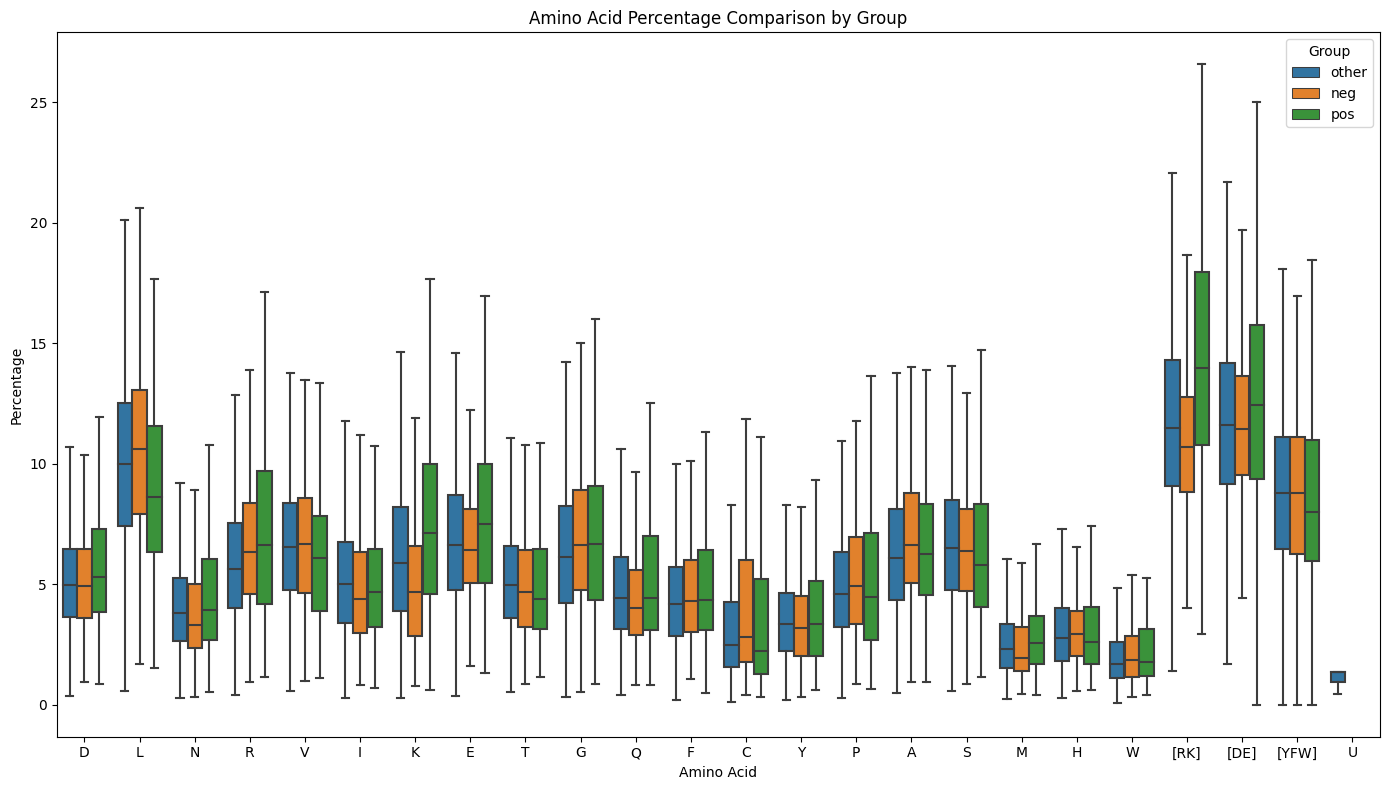

In [107]:
# Flatten the DataFrame for plotting
flat_data = []
for index, row in human_domains_composition_df.iterrows():
    for aa, percentage in row["aa_percentage"].items():
        flat_data.append({"amino_acid": aa, "percentage": percentage, "group": row["group"]})

flat_df = pd.DataFrame(flat_data)

# Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(data=flat_df, x="amino_acid", y="percentage", hue="group", showfliers= False)
plt.title("Amino Acid Percentage Comparison by Group")
plt.xlabel("Amino Acid")
plt.ylabel("Percentage")
plt.legend(title="Group")
plt.tight_layout()
plt.show()

In [167]:
test_df = human_domains_composition_df[human_domains_composition_df["prot"].isin(["P35637"])]
# test_df.explode('aa_percentage')
# Exploding the 'aa_percentage' column
df_exploded = test_df.explode('aa_percentage')



exploded_df = test_df['aa_percentage'].apply(lambda x: pd.Series(x)).reset_index()

test_df = test_df.reset_index()
# Rename the columns to 'key' and 'value'
exploded_df = exploded_df.melt(id_vars=['index'], var_name='key', value_name='value')
# print(exploded_df)
# print(test_df)
# Merge with the original DataFrame
final_df = test_df.drop(columns=['aa_percentage']).merge(exploded_df[['index', 'key', 'value']], on='index')

# Drop the 'index' column used for merging
final_df = final_df.drop(columns=['index'])



final_df

,prot,domain_ID,domain_name,full_seq,domain_coords,domain_seq,group,key,value
0,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,T,9.302326
1,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,I,9.302326
2,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,F,6.976744
3,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,V,5.813953
4,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,Q,3.488372
5,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,G,9.302326
6,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,L,3.488372
7,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,E,5.813953
8,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,N,4.651163
9,P35637,IPR000504,RNA recognition motif domain,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...,"(285, 371)",TIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETG...,pos,S,5.813953


In [206]:
human_domains_composition_df[human_domains_composition_df["group"] == "pos"].domain_name.value_counts()[:10]

RNA recognition motif domain     51
Homeobox domain                  14
Zinc finger C2H2-type            13
Zinc finger, PHD-finger           9
RBM1CTR                           9
Helicase, C-terminal              9
DEAD/DEAH box helicase domain     8
K Homology domain, type 1         7
Zinc finger, CCCH-type            7
SET domain                        5
Name: domain_name, dtype: int64

In [1]:
human_domains_composition_df

NameError: name 'human_domains_composition_df' is not defined

['RNA recognition motif domain', 'Homeobox domain', 'Zinc finger C2H2-type', 'Helicase, C-terminal', 'RBM1CTR', 'Zinc finger, PHD-finger', 'DEAD/DEAH box helicase domain', 'K Homology domain, type 1', 'Zinc finger, CCCH-type', 'Bromodomain']
.......
RNA recognition motif domain


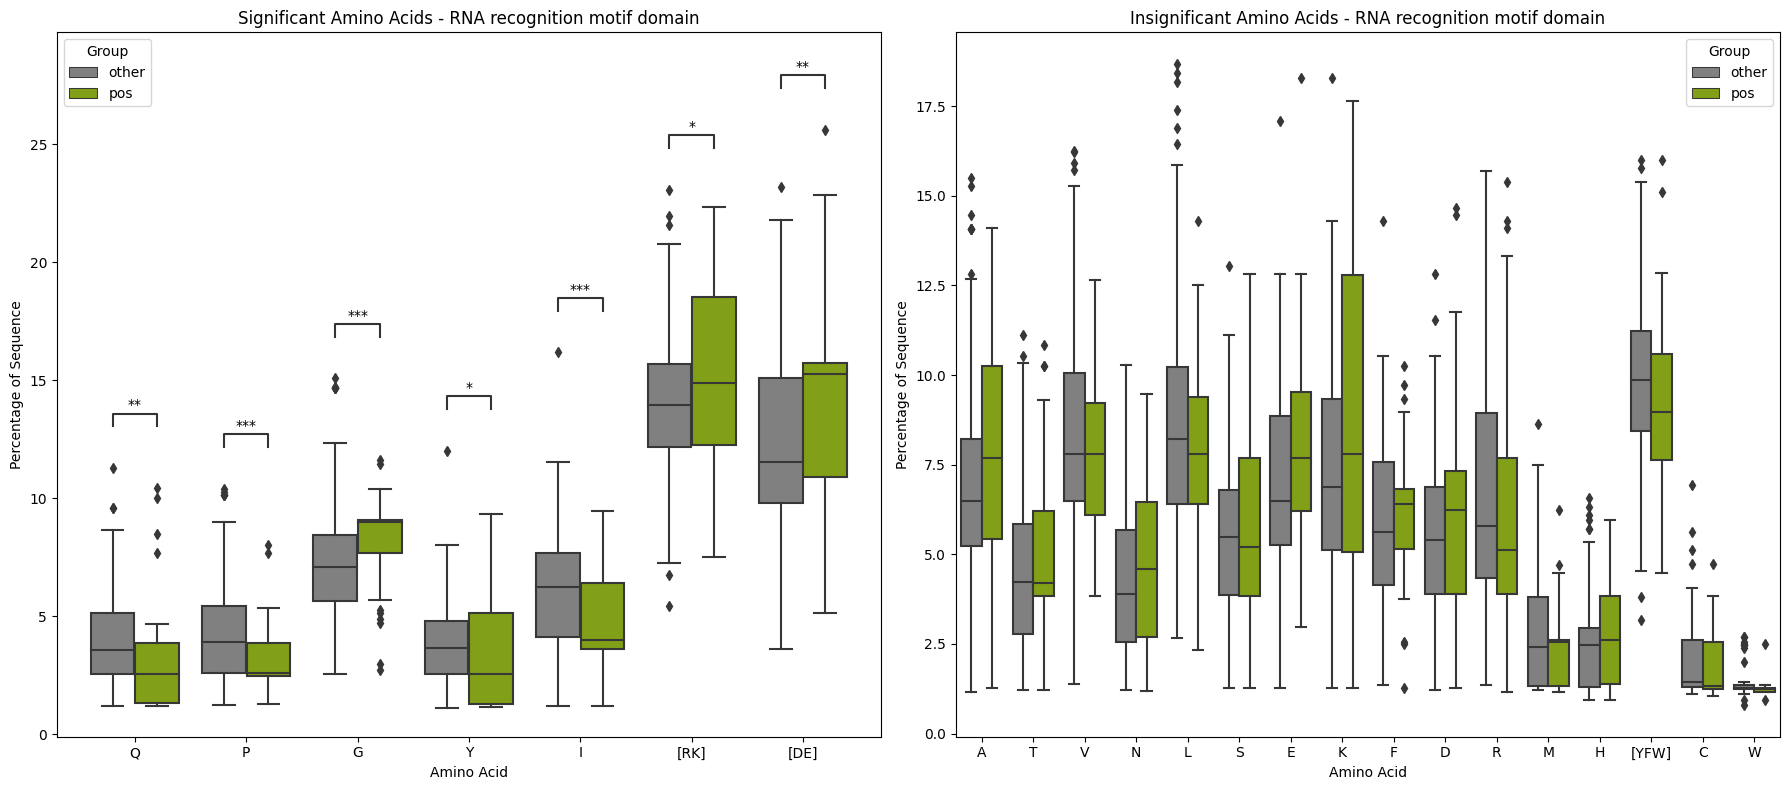

.......
Homeobox domain


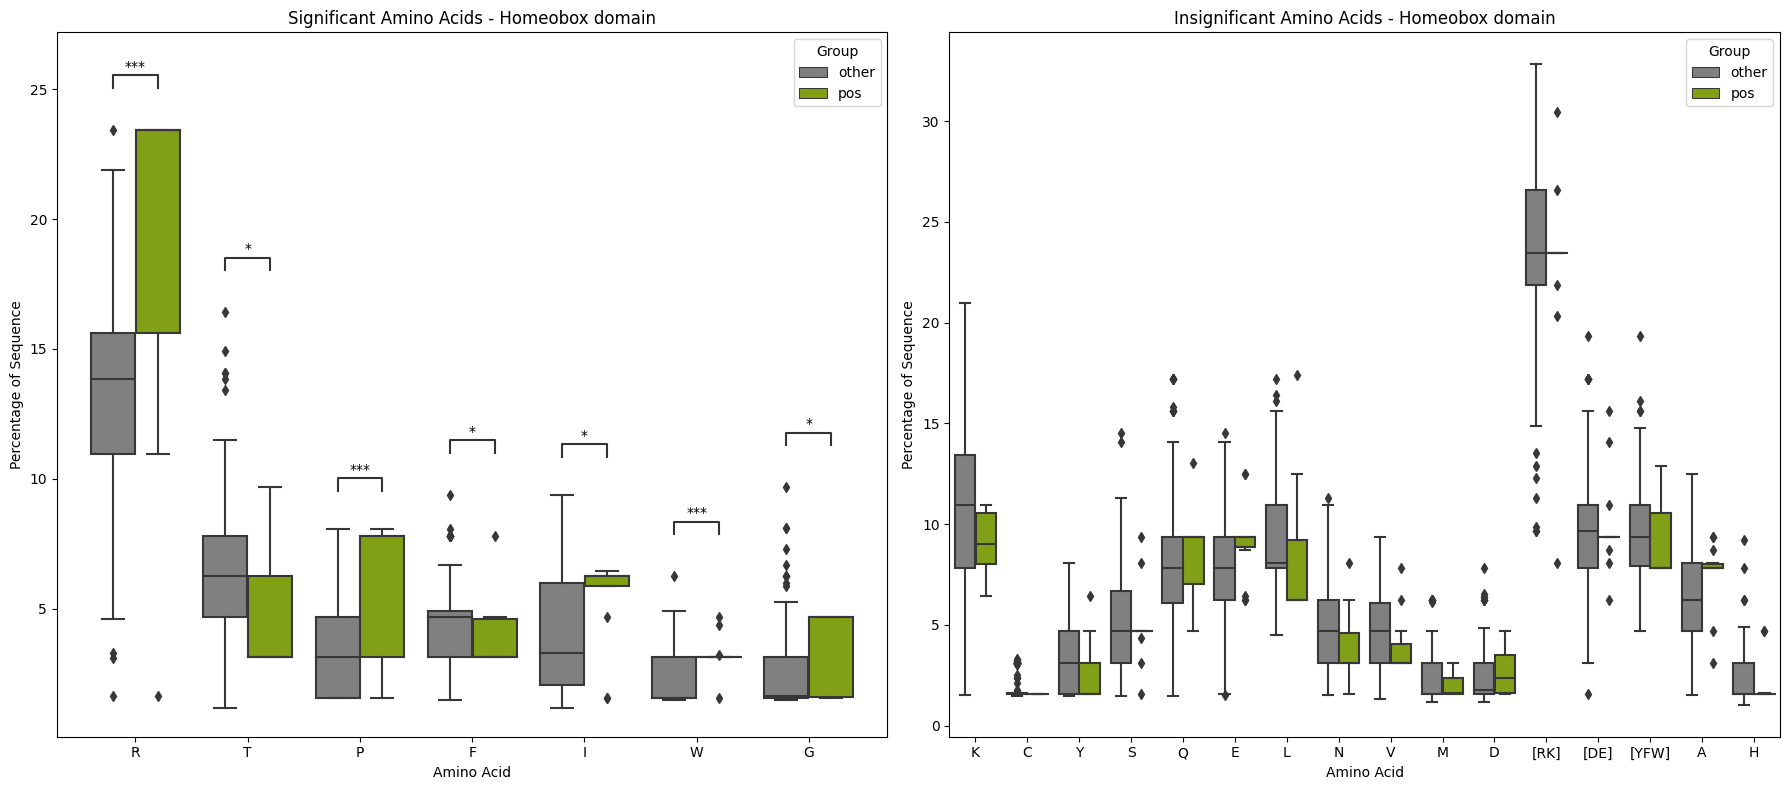

.......
Zinc finger C2H2-type


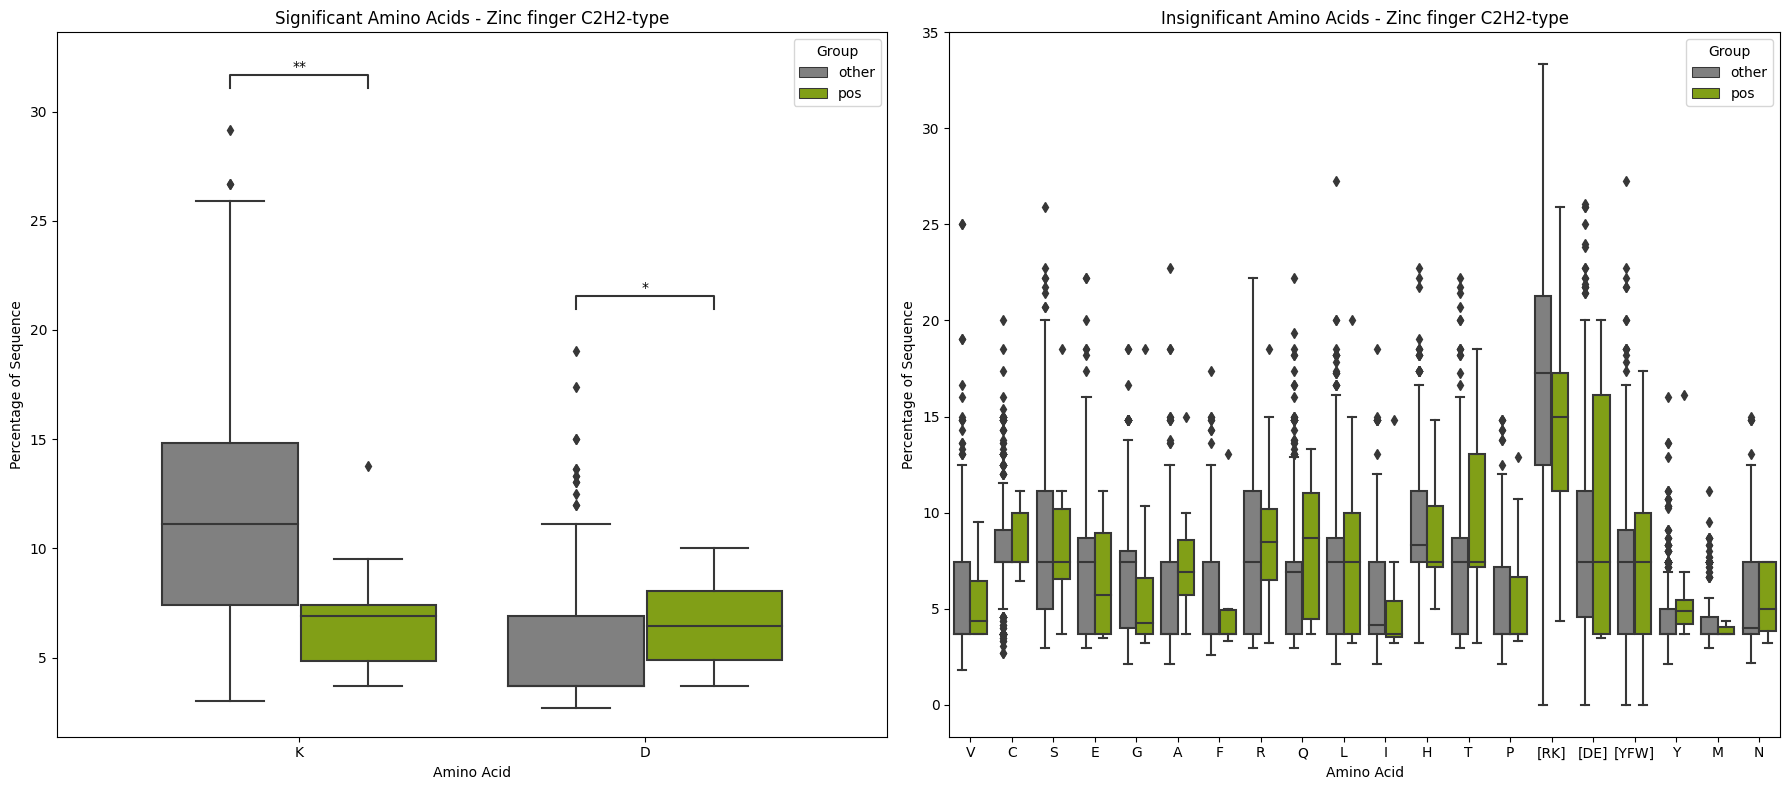

.......
Helicase, C-terminal


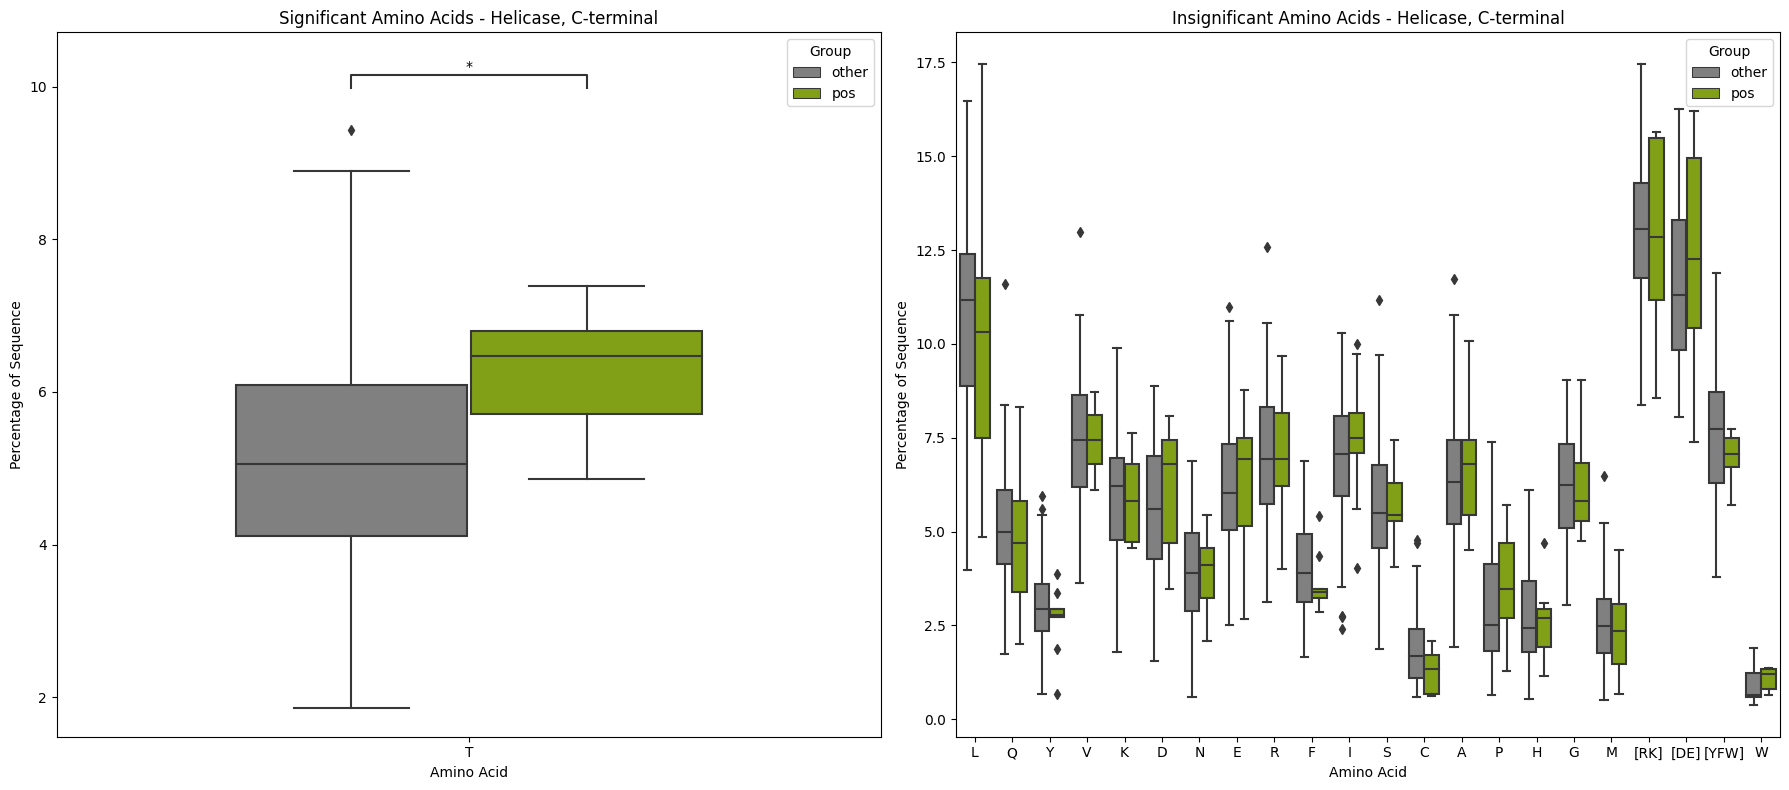

.......
RBM1CTR


ValueError: min() arg is an empty sequence

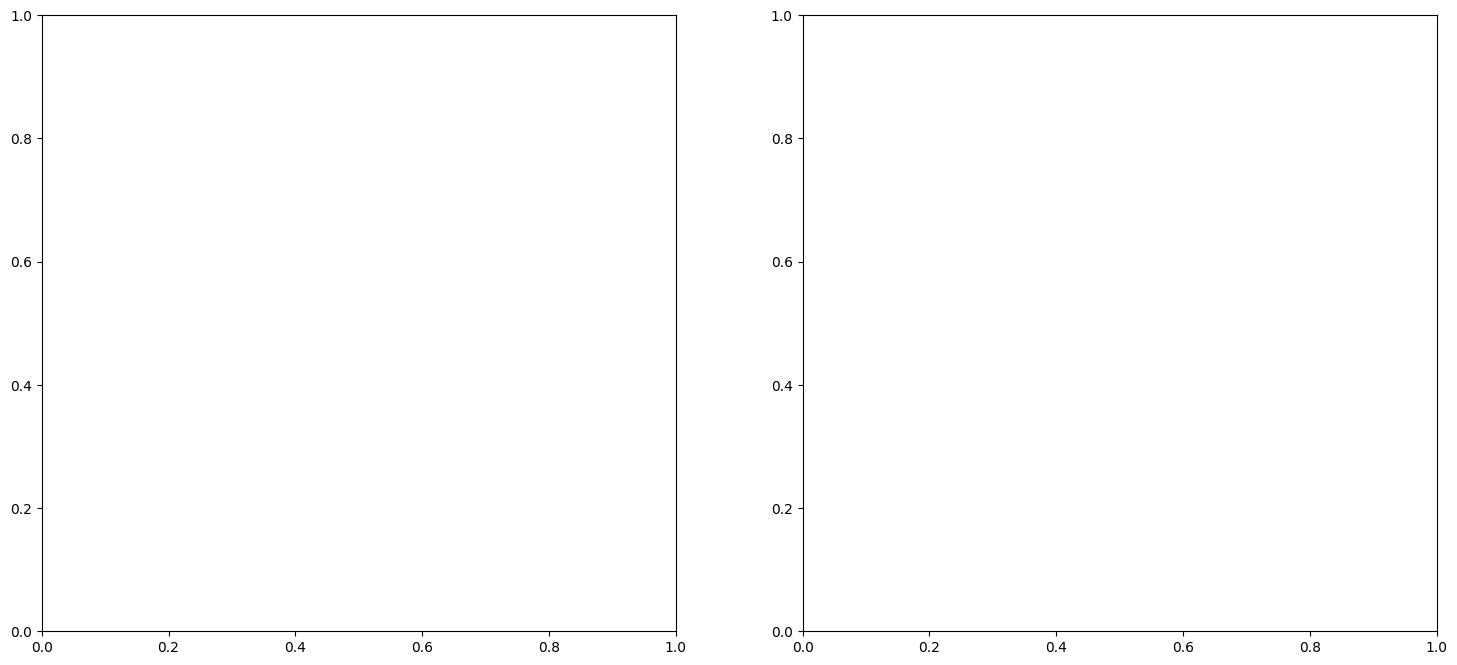

In [202]:
# Find the top 5 most common domains in the `pos` group

#### what to compare pos against

from scipy.stats import mannwhitneyu
# Define amino acid groups
aminoacid_groups = {
    'A': 'hydrophobic', 'C': 'polar', 'D': 'neg', 'E': 'neg', 'F': 'hydrophobic', 'G': 'hydrophobic', 
    'H': 'pos', 'I': 'hydrophobic', 'K': 'pos', 'L': 'hydrophobic', 'M': 'hydrophobic', 'N': 'polar',
    'P': 'hydrophobic', 'Q': 'polar', 'R': 'pos', 'S': 'polar', 'T': 'polar', 'V': 'hydrophobic',
    'W': 'hydrophobic', 'Y': 'polar'
}

compare_string = "other"
aa_metric = "aa_percentage"




top_domains = (
    human_domains_composition_df[human_domains_composition_df["group"] == "pos"]
    .groupby("domain_name")
    .size()
    .nlargest(10)
    .index
    .tolist()
)
print(top_domains)


# Filter data for the top 5 domains
filtered_df = human_domains_composition_df[human_domains_composition_df["domain_name"].isin(top_domains)]

# Flatten the DataFrame for plotting
flat_data = []
for index, row in filtered_df.iterrows():
    for aa, percentage in row[aa_metric].items():
        flat_data.append({
            "aminoacid": aa,
            "percentage": percentage,
            "group": row["group"],
            "domain": row["domain_name"],
        })

flat_df = pd.DataFrame(flat_data)
flat_df = flat_df[flat_df["group"].isin(["pos", compare_string])]

# used_AAs = ["A","R", "G"]
used_AAs = flat_df.aminoacid.unique()

flat_df = flat_df[flat_df["aminoacid"].isin(used_AAs)]
# Plotting separate graphs for each domain
for domain in top_domains:
    print(".......")
    print(domain)
    domain_data = flat_df[flat_df["domain"] == domain]
    significant_aminoacids = []
    insignificant_aminoacids = []
    pvalues = {}

    # Perform Mann-Whitney U test for each unique amino acid
    for aminoacid in domain_data['aminoacid'].unique():
        group_pos = domain_data[(domain_data['aminoacid'] == aminoacid) & (domain_data['group'] == 'pos')]['percentage']
        group_neg = domain_data[(domain_data['aminoacid'] == aminoacid) & (domain_data['group'] == compare_string)]['percentage']
        
        # Skip if either group has no data
        if group_pos.empty or group_neg.empty:
            continue
        
        # Perform the Mann-Whitney U test
        _, pvalue = mannwhitneyu(group_pos, group_neg)
        
        # If significant (p-value < 0.05), add to the list of significant amino acids
        if pvalue < 0.05:
            significant_aminoacids.append(aminoacid)
            pvalues[aminoacid] = pvalue
        else:
            insignificant_aminoacids.append(aminoacid)

    # Create two separate DataFrames: one for significant and one for insignificant amino acids
    significant_data = domain_data[domain_data['aminoacid'].isin(significant_aminoacids)]
    insignificant_data = domain_data[domain_data['aminoacid'].isin(insignificant_aminoacids)]

    # Create subplots for significant and insignificant amino acids
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

    # Plot significant amino acids on the left subplot
    sns.boxplot(data=significant_data, x="aminoacid", y="percentage", hue="group", dodge=True, palette={"pos": "#8DB600", "other": "gray"}, ax=axes[0])
    axes[0].set_title(f"Significant Amino Acids - {domain}")
    axes[0].set_xlabel("Amino Acid")
    axes[0].set_ylabel("Percentage of Sequence")
    axes[0].legend(title="Group")
    annotator = Annotator(axes[0], [[(_ , 'pos'), (_, compare_string)] for _ in significant_aminoacids], data=significant_data, y='percentage', x='aminoacid', hue='group') 
    # print(annotator)#order=
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=False, verbose=0) # ,pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"]]
    annotator.apply_test().annotate()

    # Plot insignificant amino acids on the right subplot
    sns.boxplot(data=insignificant_data, x="aminoacid", y="percentage", hue="group", dodge=True, palette={"pos": "#8DB600", "other": "gray"}, ax=axes[1])
    axes[1].set_title(f"Insignificant Amino Acids - {domain}")
    axes[1].set_xlabel("Amino Acid")
    axes[1].set_ylabel("Percentage of Sequence")
    axes[1].legend(title="Group")

    # Adjust layout to prevent overlapping of labels and titles
    plt.tight_layout()

    # Show the plots
    plt.show()

# ax = plt.gca()
# annotate_boxplots(ax, flat_df, 'neg', show_only_significant=True)


ValueError: min() arg is an empty sequence

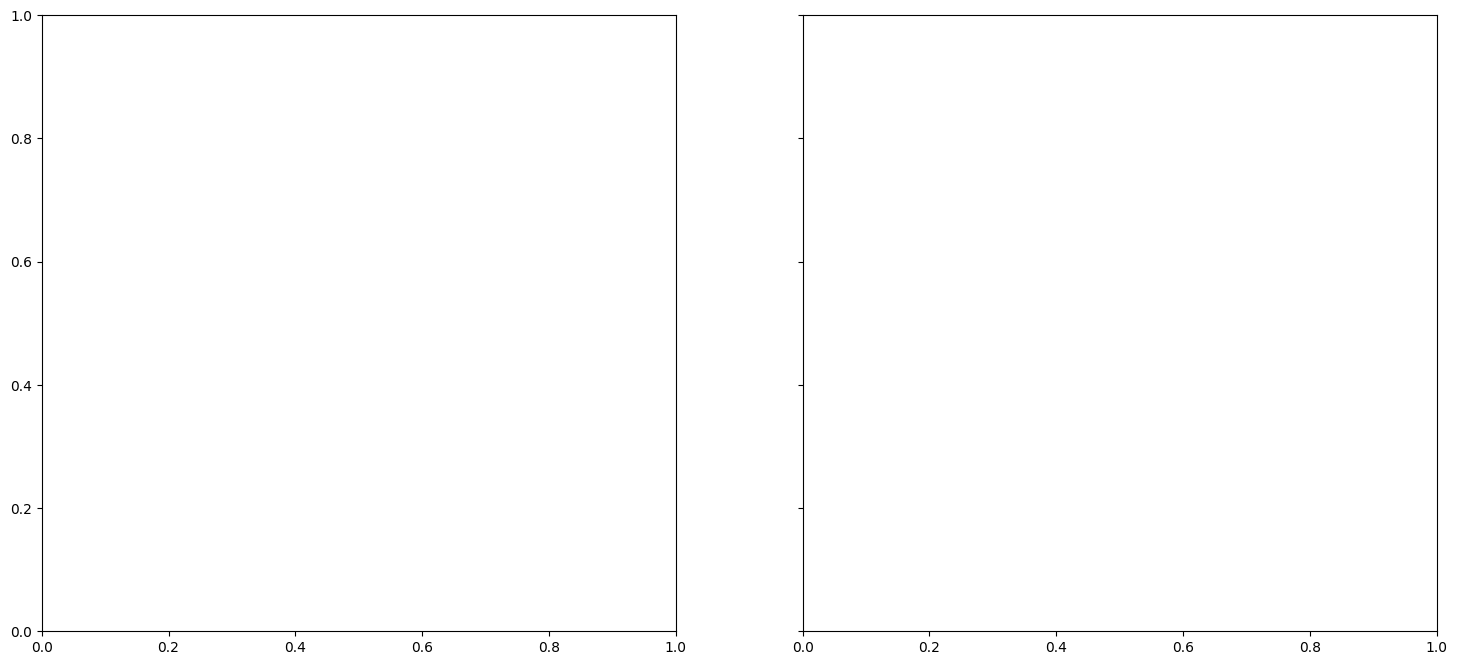

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Assuming the code before this part remains the same
# For each domain, collect significant and insignificant amino acids
significant_aminoacids = []
insignificant_aminoacids = []
pvalues = {}

# Perform Mann-Whitney U test for each unique amino acid
for aminoacid in domain_data['aminoacid'].unique():
    group_pos = domain_data[(domain_data['aminoacid'] == aminoacid) & (domain_data['group'] == 'pos')]['percentage']
    group_neg = domain_data[(domain_data['aminoacid'] == aminoacid) & (domain_data['group'] == compare_string)]['percentage']
    
    # Skip if either group has no data
    if group_pos.empty or group_neg.empty:
        continue
    
    # Perform the Mann-Whitney U test
    _, pvalue = mannwhitneyu(group_pos, group_neg)
    
    # If significant (p-value < 0.05), add to the list of significant amino acids
    if pvalue < 0.05:
        significant_aminoacids.append(aminoacid)
        pvalues[aminoacid] = pvalue
    else:
        insignificant_aminoacids.append(aminoacid)

# Create two separate DataFrames: one for significant and one for insignificant amino acids
significant_data = domain_data[domain_data['aminoacid'].isin(significant_aminoacids)]
insignificant_data = domain_data[domain_data['aminoacid'].isin(insignificant_aminoacids)]

# Create subplots for significant and insignificant amino acids
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Plot significant amino acids on the left subplot
sns.boxplot(data=significant_data, x="aminoacid", y="percentage", hue="group", dodge=True, palette={"pos": "#8DB600", "other": "gray"}, ax=axes[0])
axes[0].set_title(f"Significant Amino Acids - {domain}")
axes[0].set_xlabel("Amino Acid")
axes[0].set_ylabel("Percentage of Sequence")
axes[0].legend(title="Group")

# Plot insignificant amino acids on the right subplot
sns.boxplot(data=insignificant_data, x="aminoacid", y="percentage", hue="group", dodge=True, palette={"pos": "#8DB600", "other": "gray"}, ax=axes[1])
axes[1].set_title(f"Insignificant Amino Acids - {domain}")
axes[1].set_xlabel("Amino Acid")
axes[1].set_ylabel("Percentage of Sequence")
axes[1].legend(title="Group")

# Adjust layout to prevent overlapping of labels and titles
plt.tight_layout()

# Show the plots
plt.show()
